# Despliegue del modelo 
Este notebook tiene el objetivo de utilizar los modelos previamente entrenados para realizar predicciones

Las UNES probadas  hasta el momento con buenos resultados son las siguientes: 

- D001: UNE Norte 
- D002: UNE Sur
- D003: UNE Poniente 
- D004: UNE Oriente
- D006: Zapotlanejo
- D007: Chapala
- D040: Ocotlán 
- D041: Tequila 
- D046: Ciudad Guzmán  

**PARAMETROS DE ENTRADA**

In [1]:
UNEs = ("D001","D002", "D003", "D004", "D006", "D007", "D040", "D041", "D046")
UNEs = ("D001","D002", "D003", "D004")
categorias = ("D21", "D17")  # Estos son las categorias de tradicional y cercanias (oxxos)
semana = [14] # Lista con las semanas de interés 
year = 2024
umbral_redondeo_reja = 0.45  # Se usa para redondear los litros hacia arriba si el producto está arriba de ese decimal
factor_total = 0.94 # El total de la predicción se multiplicara por este factor 

In [2]:
import joblib
import pyodbc
import pandas as pd 
import category_encoders as ce 
from scipy.stats import mode
import datetime

**NOTAS**:

- Los catalogo , si dejar todo el  historico. 
- Productos libre por cliente, no se van a categorizar los clientes por su categoria (tradicional etc)  
- Regiones si van, hay que tomar las regiones que actualmente existen, - INTEGRAR A QUE UNE PERTENECE cada cliente en k means, ponerlo en binario esas categorías. 
- Entender el proceso de CPFR, cómo hacen la ingesta de datos de venta en sus clientes

**ESTABLECIMIENTO DE FECHAS DE LA SEMANA DESEADA**

In [3]:
# 1) Comienzo al inicio de año 
fecha_base = pd.to_datetime(arg=f"01-01-{year}", format="%d-%m-%Y") # dia, mes y año

# Dias más
dias  = semana[0] 
dias = dias - 1 
dias = dias * 7 
dias = dias - 2  # Siempre menos 2 
dias = pd.to_timedelta(arg=dias, unit="d")
print("Dias añadidos:", dias)


fecha_base = fecha_base + dias  
print("Es el dia:", fecha_base.day_name()) # Siempre tendría que cargar un sabado 
fecha_base

Dias añadidos: 89 days 00:00:00
Es el dia: Saturday


Timestamp('2024-03-30 00:00:00')

In [4]:
# Creo un DF vacio  para almacenar los resultados 
fechas = pd.DataFrame(columns= ["Fecha", "Dia",]) 

for i in range(0, 7):
    dia = pd.to_timedelta(arg=i, unit="d")
    fecha_semana = fecha_base + dia  # Esto ya es una fecha dinamica que va con la iteracion del bucle  
    
    # Sacamos el dia de la semana 
    dia_semana = fecha_semana.day_name()
    
    # Lo guardamos en un diccionario
    resultado = {"Fecha": fecha_semana, 
                 "Dia": dia_semana}  # Diccionario vacio 
     
    resultado = pd.DataFrame(data=resultado, index=[0]) # Lo pasamos a un pandas DF 
    
    # Lo concateno con mi pandas DF original
    fechas = pd.concat(objs=[fechas, resultado])
    
fechas

C:\Users\OMBARRAZA\AppData\Local\Temp\ipykernel_17932\2360344729.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fechas = pd.concat(objs=[fechas, resultado])


,Fecha,Dia
0,2024-03-30,Saturday
0,2024-03-31,Sunday
0,2024-04-01,Monday
0,2024-04-02,Tuesday
0,2024-04-03,Wednesday
0,2024-04-04,Thursday
0,2024-04-05,Friday


## 1) Ingesta de datos  
Esto con la finalidad de extraer los datos más actuales de cada cliente, particularmente su Frecuencia actual

### 1.1) Agenda actual (desde la base datos)

**AUTENTIFICACION**

In [5]:
# Credenciales del servidor
server = "192.168.0.192"  # Host 
database = "ASR"
usuarioDB = "consulta"
passwordDB = "Consult@"

# Generando la conexión
conexion = pyodbc.connect(
    f"DRIVER={{SQL SERVER}}; SERVER={server}; DATABASE={database}; UID={usuarioDB}; PWD={passwordDB}")
conexion

#### 1.1.1) Lectura de agenda actual y ventas de los ultimos días 
En esta sección se extraeran los clientes que si actualmente están agendados

In [6]:
# Obtenemos la fecha actual de ejecución, eso lo haremos para sacar 
fecha_actual = datetime.date.today()
print("Fecha actual:", fecha_actual)

fecha_inicio = fecha_actual - datetime.timedelta (days=15) # Hago esta resta de tiempo para irme  a los ultimos 15 dias de operacioin y sacar los patrones de consumo de estos ultimos 15 días , esto solo para los clientes que no hemos catalogado en el clustering, los clientes que ya están etiquedados por su segmento de mercado ya tendrán la etiqueta 
print("Fecha inicio:", fecha_inicio)

Fecha actual: 2024-06-11
Fecha inicio: 2024-05-27


In [7]:
# Alta de queris

# 1) Secuencia  o agenda actual 
query_secuencia = f"""
    select  C.ClienteClave, SEC.FrecuenciaClave, CE.EsquemaID, SEC.RUTClave, Almacen.AlmacenPadreId
    From Cliente as C
    left join Secuencia as SEC ON C.ClienteClave = SEC.ClienteClave
    left join ClienteEsquema CE ON C.ClienteClave = CE.ClienteClave
    left join Almacen on SEC.RUTClave = Almacen.AlmacenID
    where C.TipoEstado = 1
    AND C.AlmacenID IN {UNEs}
    AND CE.EsquemaID IN {categorias}
    AND SEC.FrecuenciaClave != '0000000'
    AND SEC.FrecuenciaClave IS NOT NULL
"""


# 2) Query de las ventas detalles para sacar el patron más reciente de consumo 
ventas_detalle_query = f"""
select TransProdDetalle.TransProdID, TransProdDetalle.TransProdDetalleID, TransProd.ClienteClave, ClienteEsquema.EsquemaID, TransProdDetalle.ProductoClave,
       TransProdDetalle.TipoUnidad, TransProdDetalle.Cantidad, TransProdDetalle.Precio, TransProdDetalle.Total,
       TransProdDetalle.MFechaHora, TransProdDetalle.MUsuarioID, Almacen.AlmacenPadreId
       from TransProdDetalle
       join TransProd on TransProdDetalle.TransProdID = TransProd.TransProdID
       join Almacen on TransProdDetalle.MUsuarioID = Almacen.AlmacenID
       join ClienteEsquema on TransProd.ClienteClave = ClienteEsquema.ClienteClave
        where TransProd.Tipo = 1 and TransProd.TipoFaseIntSal = 1 and TransProd.TipoFase != 0 and TransProd.TipoMovimiento = 2
        and cast(TransProdDetalle.MFechaHora as date)  between '{fecha_inicio}' and '{fecha_actual}'
         and Almacen.AlmacenPadreId in {UNEs} and ClienteEsquema.EsquemaID in {categorias};
"""
# El formato de fecha es año-mes-día 

# 3) Volumen  por producto (piezas) 
query_volumen_producto = """
        Select pd.ProductoClave, pd.PRUTipoUnidad, pd.Factor, PU.KgLts
        from ProductoDetalle as pd
        join ProductoUnidad PU on pd.ProductoClave = PU.ProductoClave and pd.PRUTipoUnidad = PU.PRUTipoUnidad
"""


**EJECUCION DEL QUERY**

In [8]:
agenda_actual = pd.read_sql(sql=query_secuencia, con=conexion, dtype_backend="pyarrow")
agenda_actual

C:\Users\OMBARRAZA\AppData\Local\Temp\ipykernel_17932\647147942.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  agenda_actual = pd.read_sql(sql=query_secuencia, con=conexion, dtype_backend="pyarrow")


,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId
0,0689870001,0000010,D21,D001005,D001
1,1269920000,0000010,D21,D001005,D001
2,0374320000,0000010,D21,D001005,D001
3,0373690001,0000010,D21,D001005,D001
4,1761650001,0000010,D21,D001005,D001
...,...,...,...,...,...
75323,0348340000,0100000,D21,D002008,D002
75324,1479490001,1000000,D21,D002008,D002
75325,0670260000,1000000,D21,D002008,D002
75326,0347950000,1000000,D21,D002008,D002


In [9]:
%%time 
ventas_detalle = pd.read_sql_query(sql=ventas_detalle_query, con=conexion, dtype_backend="pyarrow")

# Sacamos el tamaño en memoria RAM 
memoria  = ventas_detalle.memory_usage(deep=True).sum()
memoria = memoria / (1024**2)
print("Tamaño del DF (MB):", memoria)

ventas_detalle.head()

<timed exec>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


Tamaño del DF (MB): 84.3209228515625
CPU times: total: 3.75 s
Wall time: 10.8 s


,TransProdID,TransProdDetalleID,ClienteClave,EsquemaID,ProductoClave,TipoUnidad,Cantidad,Precio,Total,MFechaHora,MUsuarioID,AlmacenPadreId
0,10897F7A8F2F7328,1D380BEB9475E455,0463070000,D21,0355,1,4.0,21.70,86.80,2024-06-03 12:15:21,D004039,D004
1,10897F7A8F2F7328,25B4751EB6D6417B,0463070000,D21,0188,1,3.0,15.53,46.59,2024-06-03 12:15:25,D004039,D004
2,10897F7A8F2F7328,4BC4A07395AC9726,0463070000,D21,0025,1,2.0,7.50,15.00,2024-06-03 12:15:35,D004039,D004
3,10897F7A8F2F7328,51966B6D6CDDA974,0463070000,D21,0024,1,5.0,9.00,45.00,2024-06-03 12:15:43,D004039,D004
4,10897F7A8F2F7328,5EB99EFEACD2B609,0463070000,D21,0609,1,4.0,22.50,90.00,2024-06-03 12:15:31,D004039,D004


In [10]:
pzs_ltrs_por_producto = pd.read_sql(sql=query_volumen_producto, con=conexion, dtype_backend="pyarrow")
pzs_ltrs_por_producto.head()

# NOTA: La columna de PrutTipoUnidad auqnue es numerica expresa una categoria, 1 significa que se vende de manera individual, 8 por charola y 9 por bolsa. Estas categorias las tengo que vincular más bien con la columnas de Factor que esa si son las piezas reales.

C:\Users\OMBARRAZA\AppData\Local\Temp\ipykernel_17932\1719042460.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pzs_ltrs_por_producto = pd.read_sql(sql=query_volumen_producto, con=conexion, dtype_backend="pyarrow")


,ProductoClave,PRUTipoUnidad,Factor,KgLts
0,0005,1,1.0,0.250
1,0006,1,1.0,1.000
2,0007,1,1.0,0.250
3,0008,1,1.0,0.000
4,0009,1,1.0,0.236


### 1.2) Medianas de clientes y Clusters (parquet viene del entrenamiento del modelo)
**IMPORTANTE:** Recordemos que estos son los clusters de nivel de consumo, no los de patrones de consumo 
Se almacenaron una serie de datos CSV en el parte de entrenamiento, los que más nos interesan de acá son la mediana historica de venta del cliente en volumen

In [11]:
datos_cliente_modelo = pd.read_parquet(path="Resultados/Tablas/Mediana_Clientes.parquet", 
                                       columns=["ClienteClave", "EsquemaID", "AlmacenPadreId", "Semana", 
                                                "Year", "Frecuencia_Teorica", "Porcentaje_cumplimiento",
                                                "Mediana_semanal(L)", "Cluster"]) #Con columns nos quedamos con las columnas de interés
# Recordemos que los clusters que vemos aqui son  clusters por nivel de consumo 

datos_cliente_modelo

,ClienteClave,EsquemaID,AlmacenPadreId,Semana,Year,Frecuencia_Teorica,Porcentaje_cumplimiento,Mediana_semanal(L),Cluster
0,0100800011,D21,D001,18,2022,2,100.000000,126.000,5
1,0117970001,D21,D001,18,2022,6,83.333333,269.860,2
2,0118870001,D21,D001,18,2022,6,100.000000,164.700,2
3,0120270001,D21,D001,18,2022,6,100.000000,33.760,0
4,0127380000,D21,D046,18,2022,3,100.000000,60.110,0
...,...,...,...,...,...,...,...,...,...
1041779,1931550001,D21,D002,9,2024,1,100.000000,22.920,0
1041780,1931560001,D21,D002,9,2024,1,100.000000,21.200,0
1041781,1931610001,D21,D006,9,2024,2,100.000000,14.160,0
1041782,1931660001,D21,D002,9,2024,2,100.000000,95.200,5


In [12]:
num_clientes_modelo = len(datos_cliente_modelo["ClienteClave"].unique())
print(f"Los datos provenientes del modelo contienen {num_clientes_modelo} clientes")

Los datos provenientes del modelo contienen 25111 clientes


## 2) Tratamiento de datos 
En esta sección se estructuran el formato adecuado de los datos para poder ser utilizados en el modelo

### 2.1) Tratamiento de la agenda actual de clientes 
Sacaremos la frecuencia de visita a nivel semanal actual por clintes, esto es una de las variables que debemos incoporar para hacer la predicción del volumen total de venta por cliente

In [13]:
clientes_actuales = agenda_actual.groupby(by=["ClienteClave",
                                              "RUTClave", "EsquemaID", "AlmacenPadreId"]).size().reset_index()

clientes_actuales.rename(columns = {0:"Frecuencia_Teorica"}, inplace=True) 
clientes_actuales.reset_index(drop=True, inplace=True)
clientes_actuales

,ClienteClave,RUTClave,EsquemaID,AlmacenPadreId,Frecuencia_Teorica
0,0100110001,D001049,D21,D001,6
1,0100110002,D001019,D21,D001,6
2,0100510001,D003016,D21,D003,2
3,0100800011,D001041,D21,D001,2
4,0100820001,D001301,D21,D001,2
...,...,...,...,...,...
16989,1938790001,D001040,D21,D001,2
16990,1938800001,D001040,D21,D001,2
16991,1938810001,D001040,D21,D001,2
16992,1938820001,D001040,D21,D001,2


#### 2.1.2) Incorporación de la mediana  a la agenda actual y el cluster de consumo 
En esta sección vamos a vincular los datos de mediana, y cluster a la agenda actual que es la que realmente nos importa predeccir 

In [14]:
# Hacemos esto para quedarnos con el cluster más actual 
datos_cliente_modelo.sort_values(by=["Year", "Semana"], ascending=False, inplace=True)
datos_cliente_modelo.drop_duplicates(subset=["ClienteClave"], keep="first", inplace=True)
datos_cliente_modelo.reset_index(drop=True , inplace=True)
datos_cliente_modelo = datos_cliente_modelo[["ClienteClave", "Mediana_semanal(L)", "Cluster"]] 
datos_cliente_modelo

,ClienteClave,Mediana_semanal(L),Cluster
0,0100510001,10.80,0
1,0100900004,49.72,0
2,0100900005,28.30,0
3,0100900008,54.07,0
4,0100900009,78.31,5
...,...,...,...
25106,1358860001,23.70,0
25107,1481120001,120.27,5
25108,1773110001,121.21,5
25109,1822610001,100.95,5


In [15]:
# Vinculación de los clientes actuales con los datos del entrenamiento de mediana y cluster de volumen de consumo al que pertenecen 

clientes_actuales = pd.merge(left=clientes_actuales, right=datos_cliente_modelo, how="left", on=["ClienteClave"])
clientes_actuales

,ClienteClave,RUTClave,EsquemaID,AlmacenPadreId,Frecuencia_Teorica,Mediana_semanal(L),Cluster
0,0100110001,D001049,D21,D001,6,<NA>,NaN
1,0100110002,D001019,D21,D001,6,329.835,1.0
2,0100510001,D003016,D21,D003,2,10.8,0.0
3,0100800011,D001041,D21,D001,2,126.0,5.0
4,0100820001,D001301,D21,D001,2,<NA>,NaN
...,...,...,...,...,...,...,...
16989,1938790001,D001040,D21,D001,2,<NA>,NaN
16990,1938800001,D001040,D21,D001,2,<NA>,NaN
16991,1938810001,D001040,D21,D001,2,<NA>,NaN
16992,1938820001,D001040,D21,D001,2,<NA>,NaN


**INSPECCION DE VALORES NULOS**
Los valores nulos en este caso repreentan a clientes actuales (de la agenda actual)  que no estuvieron en el proceso de entrenamiento del modelo, por lo que no conocemos sus patrones de consumo 

In [16]:
clientes_actuales.isnull().sum()

ClienteClave            0
RUTClave                0
EsquemaID               0
AlmacenPadreId          0
Frecuencia_Teorica      0
Mediana_semanal(L)    881
Cluster               881
dtype: int64

#### 2.1.2) Tratamiento de clientes con  mediana nula   
Estos clientes tendrán un tratameiento especial para llenar esos aaspectos nulos, son clientes que no estuvieron en el proceso de entrenamiento  

In [17]:
# 1) Calcular la mediana  de consumo de los clientes por cada ruta
medianas_por_ruta = clientes_actuales.groupby(by='RUTClave')['Mediana_semanal(L)'].transform(func='median')
 # .transform('median') calcula la mediana de cada grupo y devuelve un objeto de Series del mismo tamaño que el DataFrame original, con la mediana correspondiente a cada 'Ruta'.
 
 # Es decir que nos dará un objeto (serie) de la misma longitud que el de entrada 
medianas_por_ruta

0        63.3000
1        96.3500
2        56.4650
3        90.6225
4        93.1875
          ...   
16989    41.7700
16990    41.7700
16991    41.7700
16992    41.7700
16993    41.7700
Name: Mediana_semanal(L), Length: 16994, dtype: double[pyarrow]

**Visualización del histogrma de medianas por ruta**

<Axes: title={'center': 'Medianas por ruta'}, ylabel='Frequency'>

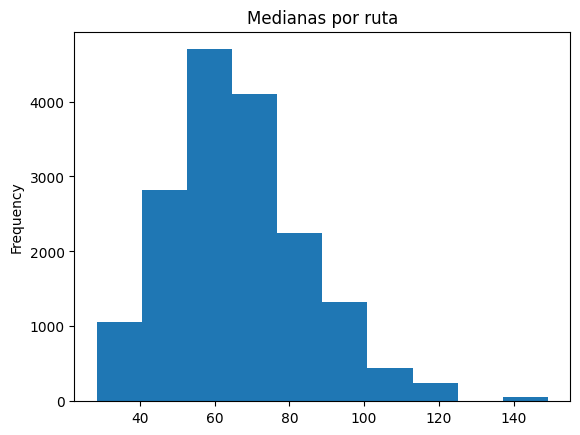

In [18]:
medianas_por_ruta.plot(kind ="hist", title = "Medianas por ruta") # Como podemos observa si existe una diferencia notable de ruta a ruta 

In [19]:
clientes_actuales

,ClienteClave,RUTClave,EsquemaID,AlmacenPadreId,Frecuencia_Teorica,Mediana_semanal(L),Cluster
0,0100110001,D001049,D21,D001,6,<NA>,NaN
1,0100110002,D001019,D21,D001,6,329.835,1.0
2,0100510001,D003016,D21,D003,2,10.8,0.0
3,0100800011,D001041,D21,D001,2,126.0,5.0
4,0100820001,D001301,D21,D001,2,<NA>,NaN
...,...,...,...,...,...,...,...
16989,1938790001,D001040,D21,D001,2,<NA>,NaN
16990,1938800001,D001040,D21,D001,2,<NA>,NaN
16991,1938810001,D001040,D21,D001,2,<NA>,NaN
16992,1938820001,D001040,D21,D001,2,<NA>,NaN


In [20]:
clientes_actuales["Mediana_semanal(L)"].fillna(value=medianas_por_ruta, inplace=True)

# Esto se debe a que la alineación basada en índices es el comportamiento predeterminado de .fillna() cuando se le pasa una Serie.

""" 
La función .fillna() en pandas es bastante inteligente cuando se trata de rellenar valores NA/NaN con valores de otra Serie. En el contexto de tu código, estás usando .fillna() para rellenar valores NA/NaN en la columna 'Mediana' con los valores correspondientes de la serie medianas_por_ruta. Aquí está lo que realmente sucede detrás de escena:

Alineación por Índices: Cuando pasas una Serie a .fillna(), pandas alinea automáticamente los valores de la Serie con el DataFrame o Serie original en el que estás llamando a .fillna(). Esto significa que .fillna() no rellena simplemente basado en el orden posicional de los datos; en cambio, utiliza los índices para determinar qué valor va dónde.
"""
clientes_actuales

,ClienteClave,RUTClave,EsquemaID,AlmacenPadreId,Frecuencia_Teorica,Mediana_semanal(L),Cluster
0,0100110001,D001049,D21,D001,6,63.3000,NaN
1,0100110002,D001019,D21,D001,6,329.8350,1.0
2,0100510001,D003016,D21,D003,2,10.8000,0.0
3,0100800011,D001041,D21,D001,2,126.0000,5.0
4,0100820001,D001301,D21,D001,2,93.1875,NaN
...,...,...,...,...,...,...,...
16989,1938790001,D001040,D21,D001,2,41.7700,NaN
16990,1938800001,D001040,D21,D001,2,41.7700,NaN
16991,1938810001,D001040,D21,D001,2,41.7700,NaN
16992,1938820001,D001040,D21,D001,2,41.7700,NaN


**INSPECCION DE VALORES NULOS**

In [21]:
clientes_actuales.isnull().sum()

ClienteClave            0
RUTClave                0
EsquemaID               0
AlmacenPadreId          0
Frecuencia_Teorica      0
Mediana_semanal(L)     12
Cluster               881
dtype: int64

**NOTA:** Vease como sigue aviendo clientes con valores nulos en Mediana, eso significa que estas rutas no tuvieron ningun cliente en el entrenamiento y no fue posible generar una mediana de los clientes de esa ruta

#### 2.1.3) Tratamiento de clientes con cluster nulo (**cluster nivel de consumo**) 
Los clientes con cluster nulo son clientes que no estuviern en el proceso de entremamiento (clienes nuevos) o que no pasaron las etapas de limpieza de datos. La manera en en que le integraremos a que cluster pertenece cada cliente es usando el cluster de moda de cada ruta.


In [22]:
print("Cantidad de clientes con valores nulos en cluster por nivel de consumo:"
      ,clientes_actuales["Cluster"].isnull().sum())


Cantidad de clientes con valores nulos en cluster por nivel de consumo: 881


In [23]:
# MUY IMPORTANTE , aqui usaremos la funcion apply dado que el resultado no tiene la misma longitud de la serie  de entrada 
modas_por_ruta = clientes_actuales.groupby(by='RUTClave')['Cluster'].apply(lambda x: mode(x)[0])
modas_por_ruta

RUTClave
D001001    0.0
D001002    0.0
D001003    0.0
D001004    5.0
D001005    5.0
          ... 
D004107    0.0
D004108    5.0
D004109    0.0
D004110    0.0
D004111    5.0
Name: Cluster, Length: 252, dtype: float64

**FillNA por medio de indices**
Vamos a utilizar los indices para hacer el llenado de valores nulos, usaremos una Serie de pandas para poder hacer este match entre valores nulos, y valores de rellenos con el indices de ambos objetos 



In [24]:
clientes_actuales.set_index(keys=clientes_actuales["RUTClave"], inplace=True)
clientes_actuales # Ahora tengo la RUTClave como indice, esto me servirá para hacer el match con la Serie de Pandas 

,ClienteClave,RUTClave,EsquemaID,AlmacenPadreId,Frecuencia_Teorica,Mediana_semanal(L),Cluster
RUTClave,,,,,,,
D001049,0100110001,D001049,D21,D001,6,63.3000,NaN
D001019,0100110002,D001019,D21,D001,6,329.8350,1.0
D003016,0100510001,D003016,D21,D003,2,10.8000,0.0
D001041,0100800011,D001041,D21,D001,2,126.0000,5.0
D001301,0100820001,D001301,D21,D001,2,93.1875,NaN
...,...,...,...,...,...,...,...
D001040,1938790001,D001040,D21,D001,2,41.7700,NaN
D001040,1938800001,D001040,D21,D001,2,41.7700,NaN
D001040,1938810001,D001040,D21,D001,2,41.7700,NaN


In [25]:
# 1) Fill NA por medio de los indices de ambos objetos (pandas DF  y el pandas Serie) 
clientes_actuales["Cluster"].fillna(value=modas_por_ruta, inplace=True)

# 2) Reseteamos el inidice 
clientes_actuales.reset_index(drop=True, inplace=True)
clientes_actuales

,ClienteClave,RUTClave,EsquemaID,AlmacenPadreId,Frecuencia_Teorica,Mediana_semanal(L),Cluster
0,0100110001,D001049,D21,D001,6,63.3000,0.0
1,0100110002,D001019,D21,D001,6,329.8350,1.0
2,0100510001,D003016,D21,D003,2,10.8000,0.0
3,0100800011,D001041,D21,D001,2,126.0000,5.0
4,0100820001,D001301,D21,D001,2,93.1875,NaN
...,...,...,...,...,...,...,...
16989,1938790001,D001040,D21,D001,2,41.7700,0.0
16990,1938800001,D001040,D21,D001,2,41.7700,0.0
16991,1938810001,D001040,D21,D001,2,41.7700,0.0
16992,1938820001,D001040,D21,D001,2,41.7700,0.0


In [26]:
# Comprobamos los clientes sin Cluster asociado 
print("Cantidad de clientes con valores nulos en cluster por nivel de consumo:"
      ,clientes_actuales["Cluster"].isnull().sum())  # Ahora son muchos menos los clientes que no tienen un cluser asociado 

Cantidad de clientes con valores nulos en cluster por nivel de consumo: 35


**NOTA IMPORTANTE:**
Hay rutas que no tienen a ningun cliente registrado por lo que no se pudo generar una mediana o promedio, y tampoco una moda para vincular los cluser por consumo, aqui un ejemplo: 


In [27]:
clientes_actuales.query("RUTClave == 'D001051'") 

,ClienteClave,RUTClave,EsquemaID,AlmacenPadreId,Frecuencia_Teorica,Mediana_semanal(L),Cluster


In [28]:
clientes_actuales.isnull().sum()

ClienteClave           0
RUTClave               0
EsquemaID              0
AlmacenPadreId         0
Frecuencia_Teorica     0
Mediana_semanal(L)    12
Cluster               35
dtype: int64

#### 2.1.4) Fill NA de los ultimos valores (clusters y medidnas finales)
Dar explicación porque hay difernecia entre valores nulos de moda y valores nulos de mediana

In [29]:
clientes_actuales[clientes_actuales["Cluster"].isnull()] # Registros con clusters con NA values 

,ClienteClave,RUTClave,EsquemaID,AlmacenPadreId,Frecuencia_Teorica,Mediana_semanal(L),Cluster
4,0100820001,D001301,D21,D001,2,93.1875,NaN
5,0100820002,D001301,D21,D001,2,93.1875,NaN
6,0100820003,D001301,D21,D001,1,93.1875,NaN
23,0101140001,D001301,D21,D001,2,93.1875,NaN
24,0101150001,D001301,D21,D001,2,93.1875,NaN
130,0206260001,D003301,D21,D003,2,68.28,NaN
131,0206270001,D003301,D21,D003,3,68.28,NaN
135,0210230002,D001302,D21,D001,2,<NA>,NaN
136,0210590001,D003301,D21,D003,2,68.28,NaN
151,0229430000,D001301,D21,D001,1,93.1875,NaN


In [30]:
clientes_actuales[clientes_actuales["Mediana_semanal(L)"].isnull()] # Registros con Mediananas con NA values 

,ClienteClave,RUTClave,EsquemaID,AlmacenPadreId,Frecuencia_Teorica,Mediana_semanal(L),Cluster
135,0210230002,D001302,D21,D001,2,<NA>,NaN
209,0261820001,D001094,D21,D001,6,<NA>,NaN
14805,1845350003,D001302,D21,D001,2,<NA>,NaN
16325,1915340001,D001302,D21,D001,3,<NA>,NaN
16329,1915340009,D001302,D21,D001,1,<NA>,NaN
16330,1915340010,D001302,D21,D001,1,<NA>,NaN
16453,1927820001,D001302,D21,D001,3,<NA>,NaN
16454,1927830001,D001302,D21,D001,3,<NA>,NaN
16651,1932070001,D001302,D21,D001,2,<NA>,NaN
16868,1935150001,D001302,D21,D001,2,<NA>,NaN


In [31]:
# 1) Llenamos la mediana global
mediana_global = clientes_actuales["Mediana_semanal(L)"].median()

clientes_actuales["Mediana_semanal(L)"].fillna(value=mediana_global, inplace=True)
clientes_actuales.isnull().sum()

ClienteClave           0
RUTClave               0
EsquemaID              0
AlmacenPadreId         0
Frecuencia_Teorica     0
Mediana_semanal(L)     0
Cluster               35
dtype: int64

In [32]:
# 2) Moda global, llenado de clusters faltantes 
clusters_moda_global = float(clientes_actuales["Cluster"].mode()) # Lo forzo a una objeto float o int para poder sacarle la moda

clientes_actuales["Cluster"].fillna(value=clusters_moda_global, inplace=True)
clientes_actuales.isnull().sum() # Vemos que ya no tenemos valores nulos 

C:\Users\OMBARRAZA\AppData\Local\Temp\ipykernel_17932\955782277.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  clusters_moda_global = float(clientes_actuales["Cluster"].mode()) # Lo forzo a una objeto float o int para poder sacarle la moda


ClienteClave          0
RUTClave              0
EsquemaID             0
AlmacenPadreId        0
Frecuencia_Teorica    0
Mediana_semanal(L)    0
Cluster               0
dtype: int64

## 3) Xgboost 

### 3.1) Lectura del modelo 

In [33]:
xgboost = joblib.load(filename='Resultados/Modelos/Xgboost/modelo_xgboost.pkl')
xgboost

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=-1,
             num_parallel_tree=None, ...)

### 3.2) Escalamiento de las variables numericas 

In [34]:
# Viualizcipon del DF a tratar
clientes_actuales["Porcentaje_cumplimiento"] = 100  # Incluimos la variable de porcentaje de cumplimiento al 100 % 
clientes_actuales.head()

,ClienteClave,RUTClave,EsquemaID,AlmacenPadreId,Frecuencia_Teorica,Mediana_semanal(L),Cluster,Porcentaje_cumplimiento
0,0100110001,D001049,D21,D001,6,63.3000,0.0,100
1,0100110002,D001019,D21,D001,6,329.8350,1.0,100
2,0100510001,D003016,D21,D003,2,10.8000,0.0,100
3,0100800011,D001041,D21,D001,2,126.0000,5.0,100
4,0100820001,D001301,D21,D001,2,93.1875,0.0,100


**ESCALAMIENTO DE LOS VALORES NUMERICOS**

In [35]:
# Lectura de las metricvas de escalameinto 
scaler = joblib.load('Resultados/scaler.pkl')
scaler

StandardScaler()

In [36]:
# Selección de las variables numericas 
numericas = clientes_actuales[["Porcentaje_cumplimiento", "Frecuencia_Teorica", "Mediana_semanal(L)"]]

# Escalamos los valores y lo metemos en un pandas DF 
numericas = pd.DataFrame(data=scaler.transform(X=numericas), columns=numericas.columns)
numericas

,Porcentaje_cumplimiento,Frecuencia_Teorica,Mediana_semanal(L)
0,0.382736,0.933225,-0.292337
1,0.382736,0.933225,2.753076
2,0.382736,-1.463761,-0.892199
3,0.382736,-1.463761,0.424070
4,0.382736,-1.463761,0.049156
...,...,...,...
16989,0.382736,-1.463761,-0.538337
16990,0.382736,-1.463761,-0.538337
16991,0.382736,-1.463761,-0.538337
16992,0.382736,-1.463761,-0.538337


In [37]:
data_set_final = clientes_actuales [["ClienteClave"]]
data_set_final["AlmacenPadreId"] = clientes_actuales [["AlmacenPadreId"]]
data_set_final["EsquemaID"] = clientes_actuales [["EsquemaID"]]
data_set_final["Semana"] = semana[0]          # CHECAR ESTO, esto tendría que estar tendro de un ciclo si vamos a hacer el pronistico de varias semanas       
data_set_final["Porcentaje_cumplimiento"] = numericas["Porcentaje_cumplimiento"]
data_set_final["Frecuencia_Teorica"] = numericas["Frecuencia_Teorica"]
data_set_final["Mediana_semanal(L)"] = numericas ["Mediana_semanal(L)"]
data_set_final["Cluster"] = clientes_actuales ["Cluster"] 
data_set_final

C:\Users\OMBARRAZA\AppData\Local\Temp\ipykernel_17932\1550555547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set_final["AlmacenPadreId"] = clientes_actuales [["AlmacenPadreId"]]
C:\Users\OMBARRAZA\AppData\Local\Temp\ipykernel_17932\1550555547.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set_final["EsquemaID"] = clientes_actuales [["EsquemaID"]]
C:\Users\OMBARRAZA\AppData\Local\Temp\ipykernel_17932\1550555547.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,ClienteClave,AlmacenPadreId,EsquemaID,Semana,Porcentaje_cumplimiento,Frecuencia_Teorica,Mediana_semanal(L),Cluster
0,0100110001,D001,D21,14,0.382736,0.933225,-0.292337,0.0
1,0100110002,D001,D21,14,0.382736,0.933225,2.753076,1.0
2,0100510001,D003,D21,14,0.382736,-1.463761,-0.892199,0.0
3,0100800011,D001,D21,14,0.382736,-1.463761,0.424070,5.0
4,0100820001,D001,D21,14,0.382736,-1.463761,0.049156,0.0
...,...,...,...,...,...,...,...,...
16989,1938790001,D001,D21,14,0.382736,-1.463761,-0.538337,0.0
16990,1938800001,D001,D21,14,0.382736,-1.463761,-0.538337,0.0
16991,1938810001,D001,D21,14,0.382736,-1.463761,-0.538337,0.0
16992,1938820001,D001,D21,14,0.382736,-1.463761,-0.538337,0.0


### 3.3) Tratamiento de variables categoricas
Lectura del codificador  

In [38]:
# Cargar el codificador (encoder)
encoder = joblib.load('Resultados/encoder.pkl')
encoder

OneHotEncoder(cols=['EsquemaID', 'AlmacenPadreId', 'Semana', 'Cluster'])

In [39]:
# Almacenamos el ID de los clientes 
ID_clientes = data_set_final[["ClienteClave"]]

# Eliminamos el ID de los clientes del dataset 
data_set_final.drop(columns=["ClienteClave"], inplace=True)


# Utilizamos el codifiador 
data_set_final_encoded = encoder.transform(X=data_set_final)
data_set_final_encoded

,AlmacenPadreId_1,AlmacenPadreId_2,AlmacenPadreId_3,AlmacenPadreId_4,AlmacenPadreId_5,AlmacenPadreId_6,AlmacenPadreId_7,AlmacenPadreId_8,AlmacenPadreId_9,EsquemaID_1,...,Semana_52,Porcentaje_cumplimiento,Frecuencia_Teorica,Mediana_semanal(L),Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6
0,1,0,0,0,0,0,0,0,0,1,...,0,0.382736,0.933225,-0.292337,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0.382736,0.933225,2.753076,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,0,1,...,0,0.382736,-1.463761,-0.892199,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0.382736,-1.463761,0.424070,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0.382736,-1.463761,0.049156,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16989,1,0,0,0,0,0,0,0,0,1,...,0,0.382736,-1.463761,-0.538337,0,0,1,0,0,0
16990,1,0,0,0,0,0,0,0,0,1,...,0,0.382736,-1.463761,-0.538337,0,0,1,0,0,0
16991,1,0,0,0,0,0,0,0,0,1,...,0,0.382736,-1.463761,-0.538337,0,0,1,0,0,0
16992,1,0,0,0,0,0,0,0,0,1,...,0,0.382736,-1.463761,-0.538337,0,0,1,0,0,0


**NOTA:** Ahora nuesto DF está listo para hacer una preddicón 

### 3.4) Ejecución de la predicción 

In [40]:
data_set_final_encoded

,AlmacenPadreId_1,AlmacenPadreId_2,AlmacenPadreId_3,AlmacenPadreId_4,AlmacenPadreId_5,AlmacenPadreId_6,AlmacenPadreId_7,AlmacenPadreId_8,AlmacenPadreId_9,EsquemaID_1,...,Semana_52,Porcentaje_cumplimiento,Frecuencia_Teorica,Mediana_semanal(L),Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6
0,1,0,0,0,0,0,0,0,0,1,...,0,0.382736,0.933225,-0.292337,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0.382736,0.933225,2.753076,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,0,1,...,0,0.382736,-1.463761,-0.892199,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0.382736,-1.463761,0.424070,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0.382736,-1.463761,0.049156,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16989,1,0,0,0,0,0,0,0,0,1,...,0,0.382736,-1.463761,-0.538337,0,0,1,0,0,0
16990,1,0,0,0,0,0,0,0,0,1,...,0,0.382736,-1.463761,-0.538337,0,0,1,0,0,0
16991,1,0,0,0,0,0,0,0,0,1,...,0,0.382736,-1.463761,-0.538337,0,0,1,0,0,0
16992,1,0,0,0,0,0,0,0,0,1,...,0,0.382736,-1.463761,-0.538337,0,0,1,0,0,0


In [41]:
prediccion = xgboost.predict(X = data_set_final_encoded)
prediccion

array([ 73.54758  , 345.37964  ,  14.5782995, ...,  44.334076 ,
        44.334076 ,  44.334076 ], dtype=float32)

In [42]:
print("Total original (L): ", prediccion.sum())

Total original (L):  1550102.2


**FACTOR TOTAL:**
Aqui multiplicaremos la prediccion por el factor total que reducirá o aumentara el volumen

In [43]:
predicciones = pd.DataFrame(data=ID_clientes)
predicciones["Volumen_Semanal(L)"] = prediccion
predicciones["Volumen_Semanal(L)"] = predicciones["Volumen_Semanal(L)"] * factor_total
print("Nuevo total:", predicciones["Volumen_Semanal(L)"].sum())
predicciones

Nuevo total: 1457096.2


,ClienteClave,Volumen_Semanal(L)
0,0100110001,69.134720
1,0100110002,324.656860
2,0100510001,13.703602
3,0100800011,105.582344
4,0100820001,68.959023
...,...,...
16989,1938790001,41.674030
16990,1938800001,41.674030
16991,1938810001,41.674030
16992,1938820001,41.674030


**Visualización histograma del volumen de predicciones**

<Axes: title={'center': 'Volumen de predicciones semanal por cliente'}, xlabel='Litros', ylabel='Frequency'>

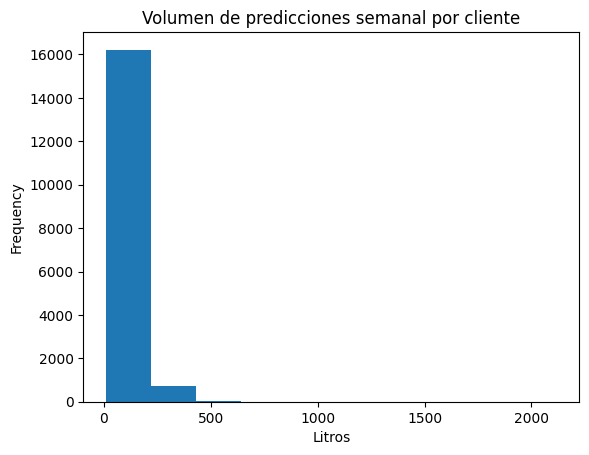

In [44]:
predicciones["Volumen_Semanal(L)"].plot(kind = "hist", 
                                        title= "Volumen de predicciones semanal por cliente", 
                                        xlabel="Litros")

### 3.5) Tratamiento de resultados, distribución del volumen por día de la semana 

#### 3.5.1) Lectura de distribución historica (de la agenda más acatual) por día de la semana 
Recordemos que en el proceos de entenamiento se tomo la agenda actual y se busco todas las semanas histoicas con esa misma agenda. El archivo de distribución historica que se va leer es justo eso, son todas las semanas historicas que tienen el mismo tipo de agenda que el actual

In [45]:
# 1) Lectura de la distribución histporica por cliente por dia de la semana 
distribucion_historica_vol= pd.read_parquet(path="Resultados/distribucion_dia_cliente.parquet", 
                                            columns=["ClienteClave", "Dia", "Porcentaje", 
                                                     "FrecuenciaClaveUnificada", "FrecuenciaTotal"])

# Cambio de nombre columna 
distribucion_historica_vol.rename(columns={"FrecuenciaTotal":"Frecuencia_Teorica_Semana"}, inplace=True)

# 2) Generar los días  reales registrados 
dias_registrados =  distribucion_historica_vol.groupby(by=["ClienteClave"]).size().reset_index()
dias_registrados.rename(columns ={0:"Dias_Registrados"}, inplace=True)

# 3) Vincular los DFs 
distribucion_historica_vol = pd.merge(left=distribucion_historica_vol, right=dias_registrados, 
                                      on=["ClienteClave"])


# 4) Generams nuevamennte la clave de secuencia unitaria (por día de la semana)
# Definimos el mapeo (que se va cambiar por que) 
mapeo = {0: '1000000', 
         1: '0100000', 
         2: '0010000',
         3: '0001000',  
         4: '0000100',
         5: '0000010'}

distribucion_historica_vol["FrecuenciaClave"] = distribucion_historica_vol["Dia"].map(arg=mapeo) 
distribucion_historica_vol.drop(columns=["Dia"], inplace=True)
distribucion_historica_vol
# NOTA: Aqui la columna que indica el día de la semana del porcenataje es la de FrecuenciaClave

### CORREGIR: Cambiar el nomnbre a  Frecuencia Toerica Semana en el script de entrenamiento

,ClienteClave,Porcentaje,FrecuenciaClaveUnificada,Frecuencia_Teorica_Semana,Dias_Registrados,FrecuenciaClave
0,0100110002,13.387281,1111110,6,6,1000000
1,0100110002,14.087324,1111110,6,6,0100000
2,0100110002,13.220603,1111110,6,6,0010000
3,0100110002,12.451325,1111110,6,6,0001000
4,0100110002,18.001854,1111110,6,6,0000100
...,...,...,...,...,...,...
96213,1931680001,2.507459,1111110,6,6,0000100
96214,1931680001,22.362195,1111110,6,6,0000010
96215,1931740001,39.208909,1010100,3,3,1000000
96216,1931740001,25.921659,1010100,3,3,0010000


#### 3.5.2) Agenda actual  
Lectura de la agenda actual

In [46]:
# 1) Lectura de la agenda actual 
agenda_actual = pd.read_sql(sql=query_secuencia, con=conexion, dtype_backend="pyarrow")

# 2) Generar el  día de la semana numerico (del 0 al 6)
agenda_actual["Dia_num"] = 1 

# Definimos el mapeo (que se va cambiar por que) 
mapeo = {'1000000': 0, 
         '0100000': 1, 
         '0010000': 2,
         '0001000':3, 
         '0000100':4,
         '0000010':5}


agenda_actual["Dia_num"] = agenda_actual["FrecuenciaClave"].map(arg=mapeo)


# 3) Generamo el total de días de visita por semana 
num_dias_visita_teorica  = agenda_actual.groupby(by=["ClienteClave"]).size().reset_index()
num_dias_visita_teorica.rename(columns={0:"Total_Dias_Teoricos"}, inplace=True)


#4) Merge con la agenda actual 
agenda_actual = pd.merge(left=agenda_actual, right=num_dias_visita_teorica,
                         on=["ClienteClave"])
agenda_actual

C:\Users\OMBARRAZA\AppData\Local\Temp\ipykernel_17932\2742239724.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  agenda_actual = pd.read_sql(sql=query_secuencia, con=conexion, dtype_backend="pyarrow")


,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId,Dia_num,Total_Dias_Teoricos
0,0665070000,0000010,D21,D001027,D001,5,6
1,0665070000,0000100,D21,D001027,D001,4,6
2,0665070000,0001000,D21,D001027,D001,3,6
3,0665070000,0010000,D21,D001027,D001,2,6
4,0665070000,0100000,D21,D001027,D001,1,6
...,...,...,...,...,...,...,...
75323,0417750000,0010000,D21,D002023,D002,2,3
75324,0417750000,1000000,D21,D002023,D002,0,3
75325,1359400001,0000100,D21,D002023,D002,4,3
75326,1359400001,0010000,D21,D002023,D002,2,3


In [47]:
# Generación de la Frecuencia Clave Unificada en el DF de agenda actual  
# 1)  Paso sus valores a una lista
agenda_actual ['ListaFrecuenciaClave'] =  agenda_actual['FrecuenciaClave'].apply(lambda x: [int(digit) for digit in x])

# 2) Union (suma) de las listas, generamos una unica lista con todos los registros unificados
Frecuencia_Clave_Unificada = agenda_actual.groupby(by=['ClienteClave'])['ListaFrecuenciaClave'].apply(lambda x: list(map(sum, zip(*x)))).reset_index()
 
# 3) Union de los elementos enteros de la lista en un solo string 
Frecuencia_Clave_Unificada["FrecuenciaClaveUnificada"] =  Frecuencia_Clave_Unificada["ListaFrecuenciaClave"].apply(lambda x: ''.join(str(numero) for numero in x))

Frecuencia_Clave_Unificada.drop(columns=["ListaFrecuenciaClave"], inplace=True)

#4) Union con el DF base
agenda_actual = pd.merge(left=agenda_actual, right=Frecuencia_Clave_Unificada, on=["ClienteClave"])
agenda_actual.drop(columns=["ListaFrecuenciaClave"], inplace=True)
agenda_actual

,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId,Dia_num,Total_Dias_Teoricos,FrecuenciaClaveUnificada
0,0665070000,0000010,D21,D001027,D001,5,6,1111110
1,0665070000,0000100,D21,D001027,D001,4,6,1111110
2,0665070000,0001000,D21,D001027,D001,3,6,1111110
3,0665070000,0010000,D21,D001027,D001,2,6,1111110
4,0665070000,0100000,D21,D001027,D001,1,6,1111110
...,...,...,...,...,...,...,...,...
75323,0417750000,0010000,D21,D002023,D002,2,3,1010100
75324,0417750000,1000000,D21,D002023,D002,0,3,1010100
75325,1359400001,0000100,D21,D002023,D002,4,3,1010100
75326,1359400001,0010000,D21,D002023,D002,2,3,1010100


**UNION**
Haremos un Join por medio de la FrecuenciaClave (es decir el día oficial de visita de la agenda actual) y el cliente. Esto lo que nos porporcionara es solo el porcentaje de ventas historicos de los días oficiales 

In [48]:
distribucion_historica_vol.drop(columns=["FrecuenciaClaveUnificada", "Dias_Registrados",
                                         "Frecuencia_Teorica_Semana"], inplace=True)
distribucion_historica_vol

,ClienteClave,Porcentaje,FrecuenciaClave
0,0100110002,13.387281,1000000
1,0100110002,14.087324,0100000
2,0100110002,13.220603,0010000
3,0100110002,12.451325,0001000
4,0100110002,18.001854,0000100
...,...,...,...
96213,1931680001,2.507459,0000100
96214,1931680001,22.362195,0000010
96215,1931740001,39.208909,1000000
96216,1931740001,25.921659,0010000


In [49]:
agenda_actual = pd.merge(left= agenda_actual, right=distribucion_historica_vol,
                         on= ["ClienteClave", "FrecuenciaClave"], how="left")
agenda_actual

,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId,Dia_num,Total_Dias_Teoricos,FrecuenciaClaveUnificada,Porcentaje
0,0665070000,0000010,D21,D001027,D001,5,6,1111110,13.532916
1,0665070000,0000100,D21,D001027,D001,4,6,1111110,16.709326
2,0665070000,0001000,D21,D001027,D001,3,6,1111110,14.140548
3,0665070000,0010000,D21,D001027,D001,2,6,1111110,18.520452
4,0665070000,0100000,D21,D001027,D001,1,6,1111110,14.793930
...,...,...,...,...,...,...,...,...,...
75323,0417750000,0010000,D21,D002023,D002,2,3,1010100,32.869560
75324,0417750000,1000000,D21,D002023,D002,0,3,1010100,28.977424
75325,1359400001,0000100,D21,D002023,D002,4,3,1010100,30.953174
75326,1359400001,0010000,D21,D002023,D002,2,3,1010100,29.900487


In [50]:
agenda_actual.isnull().sum()

ClienteClave                   0
FrecuenciaClave                0
EsquemaID                      0
RUTClave                       0
AlmacenPadreId                 0
Dia_num                        0
Total_Dias_Teoricos            0
FrecuenciaClaveUnificada       0
Porcentaje                  4724
dtype: int64

#### 3.5.3) Tratamiento final de la distribución
Aqui haremos varias cosas relavantes: 
- 1) Generamos la sumatoria total de los porcentajes por cliente
- 2) Normalzamos los porcentajes 

**INSPECCION DE NA VALUES LA AGENDA ACTUAL**

In [51]:
agenda_actual.isnull().sum()

ClienteClave                   0
FrecuenciaClave                0
EsquemaID                      0
RUTClave                       0
AlmacenPadreId                 0
Dia_num                        0
Total_Dias_Teoricos            0
FrecuenciaClaveUnificada       0
Porcentaje                  4724
dtype: int64

In [52]:
porcentaje_total = agenda_actual.groupby(by=["ClienteClave"])["Porcentaje"].sum().reset_index()
porcentaje_total.rename(columns = {"Porcentaje" :"Porcentaje_Total"}, inplace=True)
porcentaje_total

,ClienteClave,Porcentaje_Total
0,0100110001,0.000000
1,0100110002,100.000000
2,0100510001,0.000000
3,0100800011,97.211066
4,0100820001,0.000000
...,...,...
16989,1938790001,0.000000
16990,1938800001,0.000000
16991,1938810001,0.000000
16992,1938820001,0.000000


<Axes: title={'center': 'Distribución de porcentajes'}, ylabel='Frequency'>

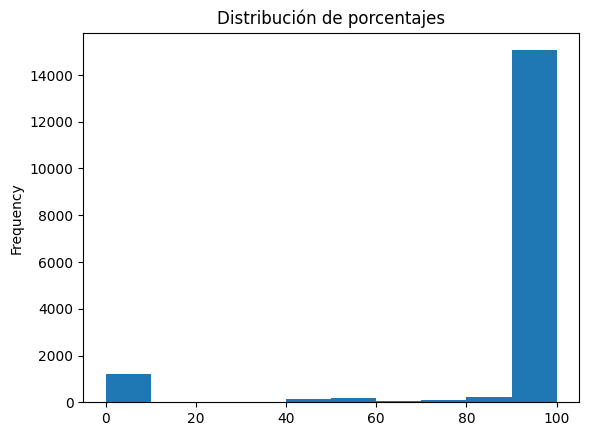

In [53]:
porcentaje_total["Porcentaje_Total"].plot(kind="hist", title="Distribución de porcentajes") 
# Como se puede observar casi todo esa realmente en 100% lo que es positivo, sin embargo tenemos que hacer la normalización de calquier forma 

Integración del total por cliente

In [54]:
agenda_actual = pd.merge(left=agenda_actual, right=porcentaje_total,
                         on=["ClienteClave"], how="left")
agenda_actual

,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId,Dia_num,Total_Dias_Teoricos,FrecuenciaClaveUnificada,Porcentaje,Porcentaje_Total
0,0665070000,0000010,D21,D001027,D001,5,6,1111110,13.532916,99.555825
1,0665070000,0000100,D21,D001027,D001,4,6,1111110,16.709326,99.555825
2,0665070000,0001000,D21,D001027,D001,3,6,1111110,14.140548,99.555825
3,0665070000,0010000,D21,D001027,D001,2,6,1111110,18.520452,99.555825
4,0665070000,0100000,D21,D001027,D001,1,6,1111110,14.793930,99.555825
...,...,...,...,...,...,...,...,...,...,...
75323,0417750000,0010000,D21,D002023,D002,2,3,1010100,32.869560,100.000000
75324,0417750000,1000000,D21,D002023,D002,0,3,1010100,28.977424,100.000000
75325,1359400001,0000100,D21,D002023,D002,4,3,1010100,30.953174,100.000000
75326,1359400001,0010000,D21,D002023,D002,2,3,1010100,29.900487,100.000000


**NORMALIZACION**

In [55]:
agenda_actual["Porcentaje_Normalizado"] = (agenda_actual["Porcentaje"] / agenda_actual["Porcentaje_Total"]) * 100
agenda_actual

,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId,Dia_num,Total_Dias_Teoricos,FrecuenciaClaveUnificada,Porcentaje,Porcentaje_Total,Porcentaje_Normalizado
0,0665070000,0000010,D21,D001027,D001,5,6,1111110,13.532916,99.555825,13.593294
1,0665070000,0000100,D21,D001027,D001,4,6,1111110,16.709326,99.555825,16.783876
2,0665070000,0001000,D21,D001027,D001,3,6,1111110,14.140548,99.555825,14.203637
3,0665070000,0010000,D21,D001027,D001,2,6,1111110,18.520452,99.555825,18.603082
4,0665070000,0100000,D21,D001027,D001,1,6,1111110,14.793930,99.555825,14.859935
...,...,...,...,...,...,...,...,...,...,...,...
75323,0417750000,0010000,D21,D002023,D002,2,3,1010100,32.869560,100.000000,32.869560
75324,0417750000,1000000,D21,D002023,D002,0,3,1010100,28.977424,100.000000,28.977424
75325,1359400001,0000100,D21,D002023,D002,4,3,1010100,30.953174,100.000000,30.953174
75326,1359400001,0010000,D21,D002023,D002,2,3,1010100,29.900487,100.000000,29.900487


**TRTAMIENTO DE NA VALUES** 
Los NA values en este caso son clientes que no estuvieron en el proceso de entrenjamiento (por lo tanto no tenemos su distribucón porcentual histortica por dia) o que su agenda actual acaba de cammbiar. En estos casos haremos una distribución general para la ruta y tipo de agenda a la que pertenece 

In [56]:
porcentajes_clientes_NA = agenda_actual.groupby(by=["FrecuenciaClaveUnificada", "Dia_num"])["Porcentaje_Normalizado"].median().reset_index()
print("Ttipo de objeto:", type(porcentajes_clientes_NA)) # Es una serie de pandas 
porcentajes_clientes_NA

Ttipo de objeto: <class 'pandas.core.frame.DataFrame'>


,FrecuenciaClaveUnificada,Dia_num,Porcentaje_Normalizado
0,0000010,5,100.0
1,0000100,4,100.0
2,0000110,4,<NA>
3,0000110,5,100.0
4,0001000,3,100.0
...,...,...,...
121,1111110,1,16.472516
122,1111110,2,15.970863
123,1111110,3,15.030452
124,1111110,4,15.341851


In [57]:
agenda_actual = pd.merge(left=agenda_actual, right=porcentajes_clientes_NA, 
                     on=['FrecuenciaClaveUnificada', 'Dia_num'], 
                     how='left', suffixes=('', '_from_df2'))
# Importante, aqui estoy haciendo una unificación, habrá una nueva columna de porcentaje normalizado que será_fro_df2 la que viene de este nuevo DF de porcnetajes_clientes_NA, esta serie dentro del DF será usando par llenar los valores NA  
agenda_actual

,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId,Dia_num,Total_Dias_Teoricos,FrecuenciaClaveUnificada,Porcentaje,Porcentaje_Total,Porcentaje_Normalizado,Porcentaje_Normalizado_from_df2
0,0665070000,0000010,D21,D001027,D001,5,6,1111110,13.532916,99.555825,13.593294,16.449896
1,0665070000,0000100,D21,D001027,D001,4,6,1111110,16.709326,99.555825,16.783876,15.341851
2,0665070000,0001000,D21,D001027,D001,3,6,1111110,14.140548,99.555825,14.203637,15.030452
3,0665070000,0010000,D21,D001027,D001,2,6,1111110,18.520452,99.555825,18.603082,15.970863
4,0665070000,0100000,D21,D001027,D001,1,6,1111110,14.793930,99.555825,14.859935,16.472516
...,...,...,...,...,...,...,...,...,...,...,...,...
75323,0417750000,0010000,D21,D002023,D002,2,3,1010100,32.869560,100.000000,32.869560,31.944597
75324,0417750000,1000000,D21,D002023,D002,0,3,1010100,28.977424,100.000000,28.977424,35.085867
75325,1359400001,0000100,D21,D002023,D002,4,3,1010100,30.953174,100.000000,30.953174,32.676688
75326,1359400001,0010000,D21,D002023,D002,2,3,1010100,29.900487,100.000000,29.900487,31.944597


In [58]:
agenda_actual["Porcentaje_Normalizado_from_df2"].isnull().sum()

18

In [59]:
serie = agenda_actual['Porcentaje_Normalizado_from_df2']
agenda_actual['Porcentaje_Normalizado'].fillna(value=serie, inplace=True)
#Importante, recordemos que cuando le damos de argumento una serie al parametro de value de la funcion fillna va hacer este proceos de llenado de valores nulos utlizando el indice de la serie y el indice del DF, como esta serie viene del mismo DF tendran el mismo indice, lo que hará que el llenado de valores nulos sea  en el mismo orden como aparecen los registros
agenda_actual

,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId,Dia_num,Total_Dias_Teoricos,FrecuenciaClaveUnificada,Porcentaje,Porcentaje_Total,Porcentaje_Normalizado,Porcentaje_Normalizado_from_df2
0,0665070000,0000010,D21,D001027,D001,5,6,1111110,13.532916,99.555825,13.593294,16.449896
1,0665070000,0000100,D21,D001027,D001,4,6,1111110,16.709326,99.555825,16.783876,15.341851
2,0665070000,0001000,D21,D001027,D001,3,6,1111110,14.140548,99.555825,14.203637,15.030452
3,0665070000,0010000,D21,D001027,D001,2,6,1111110,18.520452,99.555825,18.603082,15.970863
4,0665070000,0100000,D21,D001027,D001,1,6,1111110,14.793930,99.555825,14.859935,16.472516
...,...,...,...,...,...,...,...,...,...,...,...,...
75323,0417750000,0010000,D21,D002023,D002,2,3,1010100,32.869560,100.000000,32.869560,31.944597
75324,0417750000,1000000,D21,D002023,D002,0,3,1010100,28.977424,100.000000,28.977424,35.085867
75325,1359400001,0000100,D21,D002023,D002,4,3,1010100,30.953174,100.000000,30.953174,32.676688
75326,1359400001,0010000,D21,D002023,D002,2,3,1010100,29.900487,100.000000,29.900487,31.944597


In [60]:
agenda_actual[agenda_actual["Porcentaje_Normalizado"].isnull()]

,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId,Dia_num,Total_Dias_Teoricos,FrecuenciaClaveUnificada,Porcentaje,Porcentaje_Total,Porcentaje_Normalizado,Porcentaje_Normalizado_from_df2
670,1550250001,0000100,D21,D004031,D004,4,4,1100110,<NA>,100.000000,<NA>,<NA>
7357,1923560001,0000100,D21,D004028,D004,4,4,1100110,<NA>,0.000000,<NA>,<NA>
21451,0518980000,0010000,D21,D003006,D003,2,2,1010000,<NA>,0.000000,<NA>,<NA>
21452,0518980000,1000000,D21,D003006,D003,0,2,1010000,<NA>,0.000000,<NA>,<NA>
22284,1840910001,0000100,D21,D004031,D004,4,4,1100110,<NA>,0.000000,<NA>,<NA>
38071,0575510000,0000100,D21,D004023,D004,4,4,1100110,<NA>,63.432921,<NA>,<NA>
39877,1915090001,0000100,D21,D004034,D004,4,4,1100110,<NA>,0.000000,<NA>,<NA>
46628,0296700000,0000100,D21,D004005,D004,4,4,1100110,<NA>,45.427120,<NA>,<NA>
47799,1913750001,0000100,D21,D004010,D004,4,4,1100110,<NA>,100.000000,<NA>,<NA>
50816,1923750001,0000100,D21,D004028,D004,4,4,1100110,<NA>,0.000000,<NA>,<NA>


In [61]:
agenda_actual.drop(columns=["Porcentaje_Total", 
                            "Porcentaje_Normalizado_from_df2", "Porcentaje"], inplace=True)
agenda_actual

,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId,Dia_num,Total_Dias_Teoricos,FrecuenciaClaveUnificada,Porcentaje_Normalizado
0,0665070000,0000010,D21,D001027,D001,5,6,1111110,13.593294
1,0665070000,0000100,D21,D001027,D001,4,6,1111110,16.783876
2,0665070000,0001000,D21,D001027,D001,3,6,1111110,14.203637
3,0665070000,0010000,D21,D001027,D001,2,6,1111110,18.603082
4,0665070000,0100000,D21,D001027,D001,1,6,1111110,14.859935
...,...,...,...,...,...,...,...,...,...
75323,0417750000,0010000,D21,D002023,D002,2,3,1010100,32.869560
75324,0417750000,1000000,D21,D002023,D002,0,3,1010100,28.977424
75325,1359400001,0000100,D21,D002023,D002,4,3,1010100,30.953174
75326,1359400001,0010000,D21,D002023,D002,2,3,1010100,29.900487


In [62]:
"""
IMPORTANTE: Ahora tenemos un DF con una distribucion estadistica confiable de porcentaje de ventas por día de la semana en su agenda actual de cada cliente, incluso en los clientes que no estuvieron en el proceso de entrenamient
"""

'\nIMPORTANTE: Ahora tenemos un DF con una distribucion estadistica confiable de porcentaje de ventas por día de la semana en su agenda actual de cada cliente, incluso en los clientes que no estuvieron en el proceso de entrenamient\n'

#### 3.5.4) Integración final de resultados
Ahora que tenemos la distribucion por día de la semana correcto y el total de cliente a nivel semanal, podemos hacer la distribucion del volumen semanal por día de la semana 

In [63]:
agenda_actual.isnull().sum()

ClienteClave                 0
FrecuenciaClave              0
EsquemaID                    0
RUTClave                     0
AlmacenPadreId               0
Dia_num                      0
Total_Dias_Teoricos          0
FrecuenciaClaveUnificada     0
Porcentaje_Normalizado      18
dtype: int64

**VINCULACION DEL VOLUMEN TOTAL SEMANAL PREDICHO**

In [64]:
agenda_actual = pd.merge(left=agenda_actual, right=predicciones, on=["ClienteClave"])
agenda_actual

,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId,Dia_num,Total_Dias_Teoricos,FrecuenciaClaveUnificada,Porcentaje_Normalizado,Volumen_Semanal(L)
0,0665070000,0000010,D21,D001027,D001,5,6,1111110,13.593294,63.303040
1,0665070000,0000100,D21,D001027,D001,4,6,1111110,16.783876,63.303040
2,0665070000,0001000,D21,D001027,D001,3,6,1111110,14.203637,63.303040
3,0665070000,0010000,D21,D001027,D001,2,6,1111110,18.603082,63.303040
4,0665070000,0100000,D21,D001027,D001,1,6,1111110,14.859935,63.303040
...,...,...,...,...,...,...,...,...,...,...
75323,0417750000,0010000,D21,D002023,D002,2,3,1010100,32.869560,47.655968
75324,0417750000,1000000,D21,D002023,D002,0,3,1010100,28.977424,47.655968
75325,1359400001,0000100,D21,D002023,D002,4,3,1010100,30.953174,71.115166
75326,1359400001,0010000,D21,D002023,D002,2,3,1010100,29.900487,71.115166


**SACAMOS EL VOLUMEN POR DIA DE LA SEMANA**

In [65]:
agenda_actual["Volumen_Dia(L)"] = agenda_actual["Volumen_Semanal(L)"] * (agenda_actual["Porcentaje_Normalizado"]/100)
agenda_actual

,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId,Dia_num,Total_Dias_Teoricos,FrecuenciaClaveUnificada,Porcentaje_Normalizado,Volumen_Semanal(L),Volumen_Dia(L)
0,0665070000,0000010,D21,D001027,D001,5,6,1111110,13.593294,63.303040,8.604968
1,0665070000,0000100,D21,D001027,D001,4,6,1111110,16.783876,63.303040,10.624704
2,0665070000,0001000,D21,D001027,D001,3,6,1111110,14.203637,63.303040,8.991334
3,0665070000,0010000,D21,D001027,D001,2,6,1111110,18.603082,63.303040,11.776316
4,0665070000,0100000,D21,D001027,D001,1,6,1111110,14.859935,63.303040,9.406790
...,...,...,...,...,...,...,...,...,...,...,...
75323,0417750000,0010000,D21,D002023,D002,2,3,1010100,32.869560,47.655968,15.664307
75324,0417750000,1000000,D21,D002023,D002,0,3,1010100,28.977424,47.655968,13.809472
75325,1359400001,0000100,D21,D002023,D002,4,3,1010100,30.953174,71.115166,22.012401
75326,1359400001,0010000,D21,D002023,D002,2,3,1010100,29.900487,71.115166,21.263781


In [66]:
# Visualización de ejemplo 
agenda_actual.query("ClienteClave == '0890050040'")

,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId,Dia_num,Total_Dias_Teoricos,FrecuenciaClaveUnificada,Porcentaje_Normalizado,Volumen_Semanal(L),Volumen_Dia(L)
32062,0890050040,0000010,D17,D001111,D001,5,3,0101010,32.316744,292.133514,94.408041
32063,0890050040,0001000,D17,D001111,D001,3,3,0101010,32.911140,292.133514,96.144471
32064,0890050040,0100000,D17,D001111,D001,1,3,0101010,34.772115,292.133514,101.581003


In [67]:
fechas

,Fecha,Dia
0,2024-03-30,Saturday
0,2024-03-31,Sunday
0,2024-04-01,Monday
0,2024-04-02,Tuesday
0,2024-04-03,Wednesday
0,2024-04-04,Thursday
0,2024-04-05,Friday


**INTEGRAMOS LA FECHA EXACTA**

In [68]:
# Diccionario de equivalencias 
fechas_visita = {"1000000": "Saturday", 
                 "0100000": "Monday", 
                 "0010000": "Tuesday", 
                 "0001000": "Wednesday", 
                 "0000100":"Thursday", 
                 "0000010": "Friday"}

# Integramos el día de carga a cada predicción de venta 
agenda_actual["Dia_Carga"] = agenda_actual["FrecuenciaClave"].map(arg=fechas_visita)

# Lo vinculamos con la fecha concreta 
agenda_actual = pd.merge(left=agenda_actual, right=fechas, left_on="Dia_Carga", right_on="Dia")
agenda_actual.rename(columns={"Fecha": "Fecha_Carga"}, inplace=True)
agenda_actual.drop(columns=["Dia"], inplace=True)
agenda_actual

,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId,Dia_num,Total_Dias_Teoricos,FrecuenciaClaveUnificada,Porcentaje_Normalizado,Volumen_Semanal(L),Volumen_Dia(L),Dia_Carga,Fecha_Carga
0,0665070000,0000010,D21,D001027,D001,5,6,1111110,13.593294,63.303040,8.604968,Friday,2024-04-05
1,0597250000,0000010,D21,D001027,D001,5,6,1111110,16.519545,58.078014,9.594224,Friday,2024-04-05
2,1832190001,0000010,D21,D001027,D001,5,6,1111110,17.969939,53.990185,9.702003,Friday,2024-04-05
3,1687200001,0000010,D21,D001027,D001,5,6,1111110,18.504924,86.005386,15.915231,Friday,2024-04-05
4,1577870001,0000010,D21,D001027,D001,5,6,1111110,15.206662,70.812607,10.768234,Friday,2024-04-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75323,0318850000,1000000,D21,D003010,D003,0,3,1010100,33.670585,51.923573,17.482971,Saturday,2024-03-30
75324,1359380001,1000000,D21,D002023,D002,0,3,1010100,36.346012,64.712769,23.520510,Saturday,2024-03-30
75325,0585900000,1000000,D21,D002023,D002,0,3,1010100,35.085867,61.761932,21.669710,Saturday,2024-03-30
75326,0417750000,1000000,D21,D002023,D002,0,3,1010100,28.977424,47.655968,13.809472,Saturday,2024-03-30


### 3.6) Exportación previa de resultados (solo volumen) 

In [69]:
predicion_vol = agenda_actual.copy()
predicion_vol["ClienteClave"] = predicion_vol["ClienteClave"].astype(str)
predicion_vol["FrecuenciaClave"] = predicion_vol["FrecuenciaClave"].astype(str)
predicion_vol.to_excel("Resultados/Predicción volumen-dia por cliente.xlsx", index=False)

## 4) Kmeans 
Recordemos que en la etapa de entrenamiento nuestro K means lo hicimos tomando en consideración solo los ulitmos 3 meses de datos.  Por lo que solo se hará la lectura de un solo conjunto de centroides

### 4.1)  Importación del modelo 

In [70]:
Kmeans_model = joblib.load(filename=f'Resultados/Modelos/Kmeans/modelo_kmeans.pkl')
Kmeans_model

KMeans(n_clusters=4, n_init='auto', random_state=0)

### 4.2) Importación de datos adicionales
Los datos adicionales se refiere a las etiquetas de cada uno de los clientes integrados en el modelo 

#### 4.2.1) Clientes y sus etiquetas 
Importaremos  a qué clusters pertenecen cada cliente 

In [71]:
etiquetas_cientes = pd.read_parquet(path="Resultados/Tablas/Clientes_Cluster.parquet")
etiquetas_cientes

,ClienteClave,Cluster
0,0100110001,0
1,0100110002,0
2,0100800011,1
3,0100900001,3
4,0100900004,0
...,...,...
21214,1931660001,3
21215,1931670001,3
21216,1931680001,1
21217,1931700001,3


In [72]:
etiquetas_cientes["Cluster"].value_counts() # Visualización  de la cantidad de clientes por cluster

Cluster
3    9533
0    7370
1    2413
2    1903
Name: count, dtype: int64

#### 4.2.2) Importación de formato de columnas (distribución de productos) 

In [73]:
columnas_clusters = pd.read_parquet(path="Resultados/producto_columna.parquet")
columnas_clusters

,0006,0014,0017,0024,0025,0026,0037,0053,0055,0056,...,0886,0887,0888,0889,0890,0918,0959,0960,0961,2905


### 4.2.3) Importación de la distribución historica real de productos
En esta sección lo que pondremos es la distribución porcentual historia real de los productos, esto con la finalidad de en caso de ser necesario poder hacer una  ponderación o mezcla entre la distribución sugerida y la distribución real 

In [74]:
consumo_historico_real  = pd.read_parquet(path="Resultados/consumo_hisorico_cliente.parquet")
consumo_historico_real

,ClienteClave,0006,0014,0017,0024,0025,0026,0037,0053,0055,...,0886,0887,0888,0889,0890,0918,0959,0960,0961,2905
0,0100110001,20.047291,0.462630,0.462630,0.616840,1.799116,2.929989,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0100110002,9.046183,0.000000,0.000000,0.000000,0.126108,0.033629,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0100800011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0100900001,16.003711,2.145425,2.609301,3.884959,2.667285,9.973327,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0100900004,13.822337,0.998280,0.383954,2.380514,5.144981,9.982799,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21214,1931660001,21.402392,1.070120,0.735707,1.538297,2.675299,4.280478,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21215,1931670001,13.136681,1.866006,2.761689,3.209530,2.463128,4.329134,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21216,1931680001,4.300151,1.535768,1.650951,1.612556,2.303652,5.068035,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21217,1931700001,16.132580,3.116521,3.849820,5.133094,2.383222,6.233042,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4.3) Implementación de resultados 

**EXTRACCION DE CENTROIDES**

In [75]:
centroides = Kmeans_model.cluster_centers_
centroides = pd.DataFrame(data=centroides, columns=columnas_clusters.columns)
centroides["Cluster"] = centroides.index
centroides

,0006,0014,0017,0024,0025,0026,0037,0053,0055,0056,...,0887,0888,0889,0890,0918,0959,0960,0961,2905,Cluster
0,18.022561,0.811250,0.887064,1.145716,1.772792,4.825944,1.325848,0.014027,0.023304,0.453315,...,0.113437,0.240150,3.096375e-03,0.128855,0.009692,0.023670,0.003998,0.004708,6.203855e-23,0
1,9.065257,0.859610,1.051114,1.235285,1.478502,3.166529,0.056521,0.015411,0.021499,0.595862,...,0.065412,0.072343,4.857226e-17,0.067236,0.017764,0.012969,0.005146,0.003262,5.093157e-08,1
2,13.036844,0.940207,1.076695,1.083436,0.900945,2.619486,0.486077,0.004277,0.005402,1.683338,...,0.182211,0.479345,1.312816e-02,0.302717,0.003277,0.059355,0.031102,0.026431,5.790264e-24,2
3,15.435601,1.391844,1.642200,1.971960,2.282679,5.263540,0.254675,0.019021,0.029996,0.608032,...,0.072279,0.151086,1.370321e-02,0.112319,0.016745,0.022645,0.008862,0.006450,4.963084e-23,3


**INSPECCION DE PORCENTAJES DE DISTRIBUCION  DE PRODUCTOS POR CLUSTERS** 

In [76]:
test = centroides.T
test.rename(columns={0:"Cluster_Cero", 1:"Cluster_Uno", 2:"Cluter_Dos"}, inplace=True)
test

,Cluster_Cero,Cluster_Uno,Cluter_Dos,3
0006,1.802256e+01,9.065257e+00,1.303684e+01,1.543560e+01
0014,8.112502e-01,8.596098e-01,9.402067e-01,1.391844e+00
0017,8.870642e-01,1.051114e+00,1.076695e+00,1.642200e+00
0024,1.145716e+00,1.235285e+00,1.083436e+00,1.971960e+00
0025,1.772792e+00,1.478502e+00,9.009446e-01,2.282679e+00
...,...,...,...,...
0959,2.367043e-02,1.296921e-02,5.935498e-02,2.264460e-02
0960,3.997806e-03,5.146055e-03,3.110174e-02,8.861748e-03
0961,4.708371e-03,3.262466e-03,2.643050e-02,6.450478e-03
2905,6.203855e-23,5.093157e-08,5.790264e-24,4.963084e-23


In [77]:
try:
    print("Porcentaje total:", test["Cluster_Cero"].sum())

except:
    print("No hay este dato")

Porcentaje total: 99.99999999999997


**IDENTIFICACION DE CLIENTES ACTUALES**

In [78]:
resultados = agenda_actual.copy()
resultados

,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId,Dia_num,Total_Dias_Teoricos,FrecuenciaClaveUnificada,Porcentaje_Normalizado,Volumen_Semanal(L),Volumen_Dia(L),Dia_Carga,Fecha_Carga
0,0665070000,0000010,D21,D001027,D001,5,6,1111110,13.593294,63.303040,8.604968,Friday,2024-04-05
1,0597250000,0000010,D21,D001027,D001,5,6,1111110,16.519545,58.078014,9.594224,Friday,2024-04-05
2,1832190001,0000010,D21,D001027,D001,5,6,1111110,17.969939,53.990185,9.702003,Friday,2024-04-05
3,1687200001,0000010,D21,D001027,D001,5,6,1111110,18.504924,86.005386,15.915231,Friday,2024-04-05
4,1577870001,0000010,D21,D001027,D001,5,6,1111110,15.206662,70.812607,10.768234,Friday,2024-04-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75323,0318850000,1000000,D21,D003010,D003,0,3,1010100,33.670585,51.923573,17.482971,Saturday,2024-03-30
75324,1359380001,1000000,D21,D002023,D002,0,3,1010100,36.346012,64.712769,23.520510,Saturday,2024-03-30
75325,0585900000,1000000,D21,D002023,D002,0,3,1010100,35.085867,61.761932,21.669710,Saturday,2024-03-30
75326,0417750000,1000000,D21,D002023,D002,0,3,1010100,28.977424,47.655968,13.809472,Saturday,2024-03-30


#### 4.3.1) Integración del cluster a los clientes actuales 
En esta sección vamos a darle el ID del cluster al que pertenece cadda cliente de la agenda actual, habrá algunos clientes que no se les vincule dado que no estuvieron en el entreneaminto, a estos les daremos otro tratamiento 

In [79]:
resultados = pd.merge(left=resultados,  right=etiquetas_cientes, on=["ClienteClave"], how="left")
resultados

,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId,Dia_num,Total_Dias_Teoricos,FrecuenciaClaveUnificada,Porcentaje_Normalizado,Volumen_Semanal(L),Volumen_Dia(L),Dia_Carga,Fecha_Carga,Cluster
0,0665070000,0000010,D21,D001027,D001,5,6,1111110,13.593294,63.303040,8.604968,Friday,2024-04-05,3.0
1,0597250000,0000010,D21,D001027,D001,5,6,1111110,16.519545,58.078014,9.594224,Friday,2024-04-05,1.0
2,1832190001,0000010,D21,D001027,D001,5,6,1111110,17.969939,53.990185,9.702003,Friday,2024-04-05,3.0
3,1687200001,0000010,D21,D001027,D001,5,6,1111110,18.504924,86.005386,15.915231,Friday,2024-04-05,3.0
4,1577870001,0000010,D21,D001027,D001,5,6,1111110,15.206662,70.812607,10.768234,Friday,2024-04-05,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75323,0318850000,1000000,D21,D003010,D003,0,3,1010100,33.670585,51.923573,17.482971,Saturday,2024-03-30,0.0
75324,1359380001,1000000,D21,D002023,D002,0,3,1010100,36.346012,64.712769,23.520510,Saturday,2024-03-30,3.0
75325,0585900000,1000000,D21,D002023,D002,0,3,1010100,35.085867,61.761932,21.669710,Saturday,2024-03-30,NaN
75326,0417750000,1000000,D21,D002023,D002,0,3,1010100,28.977424,47.655968,13.809472,Saturday,2024-03-30,1.0


In [80]:
resultados.isnull().sum()

ClienteClave                   0
FrecuenciaClave                0
EsquemaID                      0
RUTClave                       0
AlmacenPadreId                 0
Dia_num                        0
Total_Dias_Teoricos            0
FrecuenciaClaveUnificada       0
Porcentaje_Normalizado        18
Volumen_Semanal(L)             0
Volumen_Dia(L)                18
Dia_Carga                      0
Fecha_Carga                    0
Cluster                     4825
dtype: int64

#### 4.3.2) Tratameinto de NA values 

**INSPECCION DE VALORES NULOS (clientes sin etiqueda de cluster)**

In [81]:
# Inpseccionamos solo el numero de clientes sin Cluster 
inspeccion = resultados.drop_duplicates(subset=["ClienteClave"], keep="first", ignore_index=True)
print("Clientes sin vinculación de cluster:",inspeccion["Cluster"].isnull().sum() )

Clientes sin vinculación de cluster: 1499


In [82]:
# Lo tomo del DF de reusltados dado que es el que contiene los datos completos 
moda_clusters_ruta = resultados.groupby(by=["RUTClave", "Cluster"]).size().reset_index()
moda_clusters_ruta.rename(columns = {0:"Clientes_Cluster", "Cluster":"Moda_Cluster"}, inplace=True)
moda_clusters_ruta.sort_values(by =["RUTClave", "Clientes_Cluster"], ascending=[True, False])
moda_clusters_ruta.drop_duplicates(subset=["RUTClave"], keep="first", ignore_index=True, inplace = True)
moda_clusters_ruta.drop(columns =["Clientes_Cluster"], inplace= True)
moda_clusters_ruta

,RUTClave,Moda_Cluster
0,D001001,0.0
1,D001002,1.0
2,D001003,0.0
3,D001004,0.0
4,D001005,1.0
...,...,...
245,D004107,0.0
246,D004108,0.0
247,D004109,0.0
248,D004110,0.0


In [83]:
# 1) Unimos este DF donde ya itentificamos que clusters están más presentes en cada ruta 
resultados = pd.merge(left= resultados, right= moda_clusters_ruta, on="RUTClave")

# 2) Usamos un Fill NA con un pandas serie para hacer la union usando el indice 
resultados["Cluster"].fillna(value= resultados["Moda_Cluster"], inplace=True) # Vease como en valor le paso la columna (que es una serie de pandas), al pasaerle esta serie hará el llenado de NA por medio del os indices 
resultados

,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId,Dia_num,Total_Dias_Teoricos,FrecuenciaClaveUnificada,Porcentaje_Normalizado,Volumen_Semanal(L),Volumen_Dia(L),Dia_Carga,Fecha_Carga,Cluster,Moda_Cluster
0,0665070000,0000010,D21,D001027,D001,5,6,1111110,13.593294,63.303040,8.604968,Friday,2024-04-05,3.0,1.0
1,0597250000,0000010,D21,D001027,D001,5,6,1111110,16.519545,58.078014,9.594224,Friday,2024-04-05,1.0,1.0
2,1832190001,0000010,D21,D001027,D001,5,6,1111110,17.969939,53.990185,9.702003,Friday,2024-04-05,3.0,1.0
3,1687200001,0000010,D21,D001027,D001,5,6,1111110,18.504924,86.005386,15.915231,Friday,2024-04-05,3.0,1.0
4,1577870001,0000010,D21,D001027,D001,5,6,1111110,15.206662,70.812607,10.768234,Friday,2024-04-05,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75293,1841780001,1000000,D21,D002023,D002,0,3,1010100,34.501116,76.708847,26.465409,Saturday,2024-03-30,3.0,1.0
75294,1359380001,1000000,D21,D002023,D002,0,3,1010100,36.346012,64.712769,23.520510,Saturday,2024-03-30,3.0,1.0
75295,0585900000,1000000,D21,D002023,D002,0,3,1010100,35.085867,61.761932,21.669710,Saturday,2024-03-30,1.0,1.0
75296,0417750000,1000000,D21,D002023,D002,0,3,1010100,28.977424,47.655968,13.809472,Saturday,2024-03-30,1.0,1.0


In [84]:
resultados.drop(columns=["Moda_Cluster"], inplace=True)
resultados.isnull().sum() # Vease que ahora Clusters no tiene valores nulos 

ClienteClave                 0
FrecuenciaClave              0
EsquemaID                    0
RUTClave                     0
AlmacenPadreId               0
Dia_num                      0
Total_Dias_Teoricos          0
FrecuenciaClaveUnificada     0
Porcentaje_Normalizado      18
Volumen_Semanal(L)           0
Volumen_Dia(L)              18
Dia_Carga                    0
Fecha_Carga                  0
Cluster                      0
dtype: int64

#### 4.3.3) Integración de la distribución de productos por cluster
Ahora que tenemos identificados a que cluster pertenece cada cliente es momento de integrar su disteibucion de productos 

In [85]:
resultados = pd.merge(left=resultados, right= centroides, on=["Cluster"], how="left")
resultados

,ClienteClave,FrecuenciaClave,EsquemaID,RUTClave,AlmacenPadreId,Dia_num,Total_Dias_Teoricos,FrecuenciaClaveUnificada,Porcentaje_Normalizado,Volumen_Semanal(L),...,0886,0887,0888,0889,0890,0918,0959,0960,0961,2905
0,0665070000,0000010,D21,D001027,D001,5,6,1111110,13.593294,63.303040,...,0.016965,0.072279,0.151086,1.370321e-02,0.112319,0.016745,0.022645,0.008862,0.006450,4.963084e-23
1,0597250000,0000010,D21,D001027,D001,5,6,1111110,16.519545,58.078014,...,0.017717,0.065412,0.072343,4.857226e-17,0.067236,0.017764,0.012969,0.005146,0.003262,5.093157e-08
2,1832190001,0000010,D21,D001027,D001,5,6,1111110,17.969939,53.990185,...,0.016965,0.072279,0.151086,1.370321e-02,0.112319,0.016745,0.022645,0.008862,0.006450,4.963084e-23
3,1687200001,0000010,D21,D001027,D001,5,6,1111110,18.504924,86.005386,...,0.016965,0.072279,0.151086,1.370321e-02,0.112319,0.016745,0.022645,0.008862,0.006450,4.963084e-23
4,1577870001,0000010,D21,D001027,D001,5,6,1111110,15.206662,70.812607,...,0.016965,0.072279,0.151086,1.370321e-02,0.112319,0.016745,0.022645,0.008862,0.006450,4.963084e-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75293,1841780001,1000000,D21,D002023,D002,0,3,1010100,34.501116,76.708847,...,0.016965,0.072279,0.151086,1.370321e-02,0.112319,0.016745,0.022645,0.008862,0.006450,4.963084e-23
75294,1359380001,1000000,D21,D002023,D002,0,3,1010100,36.346012,64.712769,...,0.016965,0.072279,0.151086,1.370321e-02,0.112319,0.016745,0.022645,0.008862,0.006450,4.963084e-23
75295,0585900000,1000000,D21,D002023,D002,0,3,1010100,35.085867,61.761932,...,0.017717,0.065412,0.072343,4.857226e-17,0.067236,0.017764,0.012969,0.005146,0.003262,5.093157e-08
75296,0417750000,1000000,D21,D002023,D002,0,3,1010100,28.977424,47.655968,...,0.017717,0.065412,0.072343,4.857226e-17,0.067236,0.017764,0.012969,0.005146,0.003262,5.093157e-08


#### 4.3.4) Tranformación de formato 
**TRANFORMACION MELT** 
En este caso queremos pasar de un formato de ancho a largo, por lo cual usaremos la funcion de pandas de MELT

In [86]:
# 1) Obtenemos una lista con el nombre de las columnas de los productos 
lista_columnas =  list(columnas_clusters.columns)

# 2) Generamos la acción melt que pasara el formato de ancho a largo 
resultados = pd.melt(frame=resultados, 
        id_vars=["ClienteClave", "FrecuenciaClave", "Fecha_Carga", "RUTClave", "AlmacenPadreId", "Volumen_Dia(L)"], 
        var_name=["ProductoClave"], 
        value_vars=lista_columnas, value_name="Porcentaje")

resultados

,ClienteClave,FrecuenciaClave,Fecha_Carga,RUTClave,AlmacenPadreId,Volumen_Dia(L),ProductoClave,Porcentaje
0,0665070000,0000010,2024-04-05,D001027,D001,8.604968,0006,1.543560e+01
1,0597250000,0000010,2024-04-05,D001027,D001,9.594224,0006,9.065257e+00
2,1832190001,0000010,2024-04-05,D001027,D001,9.702003,0006,1.543560e+01
3,1687200001,0000010,2024-04-05,D001027,D001,15.915231,0006,1.543560e+01
4,1577870001,0000010,2024-04-05,D001027,D001,10.768234,0006,1.543560e+01
...,...,...,...,...,...,...,...,...
8132179,1841780001,1000000,2024-03-30,D002023,D002,26.465409,2905,4.963084e-23
8132180,1359380001,1000000,2024-03-30,D002023,D002,23.520510,2905,4.963084e-23
8132181,0585900000,1000000,2024-03-30,D002023,D002,21.669710,2905,5.093157e-08
8132182,0417750000,1000000,2024-03-30,D002023,D002,13.809472,2905,5.093157e-08


**GENERACION DE VOLUMEN POR PRODUCTO**

In [87]:
# 1) Generamos el volumen por producto 
resultados["Volumen_Producto(L)"] = resultados["Volumen_Dia(L)"] *   (resultados["Porcentaje"]/100)
print("Volumen total:", resultados["Volumen_Producto(L)"].sum())
resultados

Volumen total: 1465836.8375085394


,ClienteClave,FrecuenciaClave,Fecha_Carga,RUTClave,AlmacenPadreId,Volumen_Dia(L),ProductoClave,Porcentaje,Volumen_Producto(L)
0,0665070000,0000010,2024-04-05,D001027,D001,8.604968,0006,1.543560e+01,1.328229e+00
1,0597250000,0000010,2024-04-05,D001027,D001,9.594224,0006,9.065257e+00,8.697410e-01
2,1832190001,0000010,2024-04-05,D001027,D001,9.702003,0006,1.543560e+01,1.497562e+00
3,1687200001,0000010,2024-04-05,D001027,D001,15.915231,0006,1.543560e+01,2.456612e+00
4,1577870001,0000010,2024-04-05,D001027,D001,10.768234,0006,1.543560e+01,1.662142e+00
...,...,...,...,...,...,...,...,...,...
8132179,1841780001,1000000,2024-03-30,D002023,D002,26.465409,2905,4.963084e-23,1.313500e-23
8132180,1359380001,1000000,2024-03-30,D002023,D002,23.520510,2905,4.963084e-23,1.167343e-23
8132181,0585900000,1000000,2024-03-30,D002023,D002,21.669710,2905,5.093157e-08,1.103672e-08
8132182,0417750000,1000000,2024-03-30,D002023,D002,13.809472,2905,5.093157e-08,7.033381e-09


#### 4.3.5) Generación de piezas 
En esta sección tomaremos el volumne por producto y lo tranformaremos a piezas.

**NOTA IMPORTANTE:** En SAP las piezas son piezas individuales, no importa que se comercialice en paquetes de una X cantidad. Las piezas tienen que ser de forma INDIVIDUAL  

In [88]:
pzs_ltrs_por_producto = pd.read_sql(sql=query_volumen_producto, con=conexion, dtype_backend="pyarrow")
pzs_ltrs_por_producto

# NOTA: La columna de PrutTipoUnidad auqnue es numerica expresa una categoria, 1 significa que se vende de manera individual, 8 por charola y 9 por bolsa. Estas categorias las tengo que vincular más bien con la columnas de Factor que esa si son las piezas reales.

C:\Users\OMBARRAZA\AppData\Local\Temp\ipykernel_17932\4229373210.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pzs_ltrs_por_producto = pd.read_sql(sql=query_volumen_producto, con=conexion, dtype_backend="pyarrow")


,ProductoClave,PRUTipoUnidad,Factor,KgLts
0,0005,1,1.0,0.250
1,0006,1,1.0,1.000
2,0007,1,1.0,0.250
3,0008,1,1.0,0.000
4,0009,1,1.0,0.236
...,...,...,...,...
728,2906,1,1.0,0.000
729,2907,1,1.0,0.000
730,2908,1,1.0,0.000
731,3002905,1,1.0,0.000


In [89]:
# 1) Solo me interesan estas columnas 
pzs_producto = pzs_ltrs_por_producto.drop(columns=["PRUTipoUnidad"])

# 2) Tengo que sacar el volumen indiciodual 
pzs_producto["Litros_Pieza"] = pzs_producto["KgLts"] / pzs_producto["Factor"]
pzs_producto

,ProductoClave,Factor,KgLts,Litros_Pieza
0,0005,1.0,0.250,0.250
1,0006,1.0,1.000,1.000
2,0007,1.0,0.250,0.250
3,0008,1.0,0.000,0.000
4,0009,1.0,0.236,0.236
...,...,...,...,...
728,2906,1.0,0.000,0.000
729,2907,1.0,0.000,0.000
730,2908,1.0,0.000,0.000
731,3002905,1.0,0.000,0.000


In [90]:
resultados = pd.merge(left=resultados, right=pzs_producto, on="ProductoClave", how="left")
resultados

,ClienteClave,FrecuenciaClave,Fecha_Carga,RUTClave,AlmacenPadreId,Volumen_Dia(L),ProductoClave,Porcentaje,Volumen_Producto(L),Factor,KgLts,Litros_Pieza
0,0665070000,0000010,2024-04-05,D001027,D001,8.604968,0006,1.543560e+01,1.328229e+00,1.0,1.000,1.000
1,0597250000,0000010,2024-04-05,D001027,D001,9.594224,0006,9.065257e+00,8.697410e-01,1.0,1.000,1.000
2,1832190001,0000010,2024-04-05,D001027,D001,9.702003,0006,1.543560e+01,1.497562e+00,1.0,1.000,1.000
3,1687200001,0000010,2024-04-05,D001027,D001,15.915231,0006,1.543560e+01,2.456612e+00,1.0,1.000,1.000
4,1577870001,0000010,2024-04-05,D001027,D001,10.768234,0006,1.543560e+01,1.662142e+00,1.0,1.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...
10014629,1841780001,1000000,2024-03-30,D002023,D002,26.465409,2905,4.963084e-23,1.313500e-23,1.0,0.001,0.001
10014630,1359380001,1000000,2024-03-30,D002023,D002,23.520510,2905,4.963084e-23,1.167343e-23,1.0,0.001,0.001
10014631,0585900000,1000000,2024-03-30,D002023,D002,21.669710,2905,5.093157e-08,1.103672e-08,1.0,0.001,0.001
10014632,0417750000,1000000,2024-03-30,D002023,D002,13.809472,2905,5.093157e-08,7.033381e-09,1.0,0.001,0.001


**GENERACION DE PIEZAS**

In [91]:
# Aplicamos un redonde simploe a las piezas 
resultados["Piezas"] =  round(resultados["Volumen_Producto(L)"] / resultados["Litros_Pieza"]) 

# IMPORTNATE: generamos nuevamente el volumen pero yua con las piezaas redondeadas (por lo que es volumen redondeado) 
resultados["Volumen_Producto(L)"] = resultados["Piezas"] * resultados["Litros_Pieza"]
resultados

,ClienteClave,FrecuenciaClave,Fecha_Carga,RUTClave,AlmacenPadreId,Volumen_Dia(L),ProductoClave,Porcentaje,Volumen_Producto(L),Factor,KgLts,Litros_Pieza,Piezas
0,0665070000,0000010,2024-04-05,D001027,D001,8.604968,0006,1.543560e+01,1.0,1.0,1.000,1.000,1.0
1,0597250000,0000010,2024-04-05,D001027,D001,9.594224,0006,9.065257e+00,1.0,1.0,1.000,1.000,1.0
2,1832190001,0000010,2024-04-05,D001027,D001,9.702003,0006,1.543560e+01,1.0,1.0,1.000,1.000,1.0
3,1687200001,0000010,2024-04-05,D001027,D001,15.915231,0006,1.543560e+01,2.0,1.0,1.000,1.000,2.0
4,1577870001,0000010,2024-04-05,D001027,D001,10.768234,0006,1.543560e+01,2.0,1.0,1.000,1.000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10014629,1841780001,1000000,2024-03-30,D002023,D002,26.465409,2905,4.963084e-23,0.0,1.0,0.001,0.001,0.0
10014630,1359380001,1000000,2024-03-30,D002023,D002,23.520510,2905,4.963084e-23,0.0,1.0,0.001,0.001,0.0
10014631,0585900000,1000000,2024-03-30,D002023,D002,21.669710,2905,5.093157e-08,0.0,1.0,0.001,0.001,0.0
10014632,0417750000,1000000,2024-03-30,D002023,D002,13.809472,2905,5.093157e-08,0.0,1.0,0.001,0.001,0.0


#### 4.3.6) Agregación de resultados a nivel ruta 
Ahora que tenemos las piezas por cliente, nos interesa hacer una agregación a nivel ruta. Estos resultados a nivel ruta tendrán que ser a su vez redondeados nuevamente para que las piezas cargadas por día correspondana a las piezas que se ponen en una reja

**NOTA SUPER IMPORTANTE;** Este redondeo va provocar que haya una diferencia entre la predicción a nivel cliente y la predicción a nivel ruta (dado el redondeo a rejas)

**RESULTADOS A NIVEL RUTA**

In [92]:
resultados_ruta = resultados.groupby(by=["RUTClave", "AlmacenPadreId", "FrecuenciaClave", "Fecha_Carga", "ProductoClave", "Litros_Pieza"])[["Volumen_Producto(L)", "Piezas"]].sum().reset_index()

# Mapeo de valores 
dias = {"1000000": "Lunes", 
        "0100000": "Martes", 
        "0010000": "Miercoles", 
        "0001000": "Jueves", 
        "0000100":"Vienres",
        "0000010": "Sabado"
        }

# Cambio de nombre
resultados_ruta.rename(columns ={"Volumen_Producto(L)": "Volumen_Productos(L)"}, inplace=True)

# Generación del día de la venta 
resultados_ruta["Dia_venta"] = resultados_ruta["FrecuenciaClave"].map(arg = dias)
resultados_ruta

,RUTClave,AlmacenPadreId,FrecuenciaClave,Fecha_Carga,ProductoClave,Litros_Pieza,Volumen_Productos(L),Piezas,Dia_venta
0,D001001,D001,0000010,2024-04-05,0006,1.000000,90.00,90.0,Sabado
1,D001001,D001,0000010,2024-04-05,0014,0.250000,4.50,18.0,Sabado
2,D001001,D001,0000010,2024-04-05,0017,0.250000,4.75,19.0,Sabado
3,D001001,D001,0000010,2024-04-05,0024,0.250000,6.50,26.0,Sabado
4,D001001,D001,0000010,2024-04-05,0025,0.250000,10.25,41.0,Sabado
...,...,...,...,...,...,...,...,...,...
169495,D004111,D004,1000000,2024-03-30,0960,0.235833,0.00,0.0,Lunes
169496,D004111,D004,1000000,2024-03-30,0960,0.236000,0.00,0.0,Lunes
169497,D004111,D004,1000000,2024-03-30,0961,0.235833,0.00,0.0,Lunes
169498,D004111,D004,1000000,2024-03-30,0961,0.236000,0.00,0.0,Lunes


## 5) Tratamiento de resultados 
**IMPORTANTE:** Agregar esta nueva sección, esta sección realmente debería de empezar más arriba, identificar realmente desde donde la puedo jalar

**REDONDEO REJAS**


In [93]:
import pandas as pd 
from hdbcli import dbapi

contraseña = "20S@pqlik"
# Establece los detalles de conexión
connection = dbapi.connect(
    address='192.168.198.234',
    port="30241",  # Generalmente es 39015
    user='QLIKSAP',
    password=contraseña)

# Crea un objeto cursor
cursor = connection.cursor()
cursor

In [94]:
query =  """
select MATNR as ProductoClave, MEINH as Unidad, UMREZ as Piezas_en_reja 
from  SAPABAP1.MARM where MEINH in ('RJ', 'CH')  ;
"""
# IMPORTANTE: el RJ es rejas y el CH es charlas, hay productos que se suben  a las unidades en rejas y otros en charolas 

# CABECERO la llave es la columna PURCH__NO_C, 
cursor.execute(operation=query)  # el formato es año, mes y 
# Recuperar todos los resultados

piezas_reja = cursor.fetchall()

col_names = piezas_reja[0].column_names

# Lo pasamos a un pandas DF 
piezas_reja= pd.DataFrame(data=piezas_reja, columns=col_names)
piezas_reja

,PRODUCTOCLAVE,UNIDAD,PIEZAS_EN_REJA
0,000000000000000023,CH,12
1,000000000000000885,CH,12
2,000000000000000787,CH,6
3,000000000000000882,CH,12
4,000000000000000845,RJ,30
...,...,...,...
536,000000000000000898,CH,12
537,000000000000000018,CH,12
538,000000000000000631,RJ,10
539,000000000000000269,RJ,12


Tratamiento del query, nos quedamos con los ultimos 4 digitos de la columna producto clave 

In [95]:
# 1) Generamos la funcion 
# Nos quedamos con los primeros 4 caracteres del registro de ProductroClave 
def acotar(string:str) -> str:
    # Lo pasamos a una lista 
    lista = list(string) 

    # Nos quedamos con los ultimos 4 objetos de la lista 
    resultado = lista
    n = 4  # reemplaza 4 con el número de elementos que deseas obtener
    resultado = resultado[-n:]
    
    # Unimos los objetos de la lista 
    resultado = ''.join(resultado)

    return resultado


# 2) Aplicamos la funcion 
piezas_reja["ProductoClave"] = piezas_reja["PRODUCTOCLAVE"].transform(func=acotar)
piezas_reja.drop(columns=["PRODUCTOCLAVE"], inplace=True)
piezas_reja

,UNIDAD,PIEZAS_EN_REJA,ProductoClave
0,CH,12,0023
1,CH,12,0885
2,CH,6,0787
3,CH,12,0882
4,RJ,30,0845
...,...,...,...
536,CH,12,0898
537,CH,12,0018
538,RJ,10,0631
539,RJ,12,0269


**UNIORLO CON EL DF DE INTERES**

In [96]:
resultados_ruta = pd.merge(left=resultados_ruta, right=piezas_reja, on=["ProductoClave"], how="left")
resultados_ruta

,RUTClave,AlmacenPadreId,FrecuenciaClave,Fecha_Carga,ProductoClave,Litros_Pieza,Volumen_Productos(L),Piezas,Dia_venta,UNIDAD,PIEZAS_EN_REJA
0,D001001,D001,0000010,2024-04-05,0006,1.000000,90.00,90.0,Sabado,RJ,16
1,D001001,D001,0000010,2024-04-05,0014,0.250000,4.50,18.0,Sabado,RJ,25
2,D001001,D001,0000010,2024-04-05,0017,0.250000,4.75,19.0,Sabado,RJ,25
3,D001001,D001,0000010,2024-04-05,0024,0.250000,6.50,26.0,Sabado,RJ,25
4,D001001,D001,0000010,2024-04-05,0025,0.250000,10.25,41.0,Sabado,RJ,25
...,...,...,...,...,...,...,...,...,...,...,...
169495,D004111,D004,1000000,2024-03-30,0960,0.235833,0.00,0.0,Lunes,CH,24
169496,D004111,D004,1000000,2024-03-30,0960,0.236000,0.00,0.0,Lunes,CH,24
169497,D004111,D004,1000000,2024-03-30,0961,0.235833,0.00,0.0,Lunes,CH,24
169498,D004111,D004,1000000,2024-03-30,0961,0.236000,0.00,0.0,Lunes,CH,24


INSPECCION DE NA VALUES  

In [97]:
resultados_ruta.isnull().sum()

RUTClave                   0
AlmacenPadreId             0
FrecuenciaClave            0
Fecha_Carga                0
ProductoClave              0
Litros_Pieza               0
Volumen_Productos(L)       0
Piezas                     0
Dia_venta                  0
UNIDAD                  3000
PIEZAS_EN_REJA          3000
dtype: int64

**LLENADO DE NA VALUES**
IMPORTANTE: Al parecer las piezas quie faltan son productos en cubetas, no se cargan en rejas o en charlos, sino de manera individual, por lo que sustituiremos los valores falantes de Unidades que sea = 1 

In [98]:
resultados_ruta["UNIDAD"].fillna(value="PZ", inplace=True)
resultados_ruta["PIEZAS_EN_REJA"].fillna(value=1, inplace=True)
resultados_ruta.isnull().sum()

RUTClave                0
AlmacenPadreId          0
FrecuenciaClave         0
Fecha_Carga             0
ProductoClave           0
Litros_Pieza            0
Volumen_Productos(L)    0
Piezas                  0
Dia_venta               0
UNIDAD                  0
PIEZAS_EN_REJA          0
dtype: int64

**REDONDEO PERSONALIZADO DE LAS REJAS**
Tomaremos un umbral personalizado para hacer el redondeo 

In [99]:
# 1) Definimos la funcion 
def redondeo(numero:float) -> int:
    numero = float(numero) # lo forazamos primero a que sea float 
    entero =  int(numero)
    decimal = numero - entero

    if decimal >= umbral_redondeo_reja:      #### UMBRAL !!! 
        resultado = entero + 1 
    else:
        resultado = entero
    
    return resultado


# 2) Sacamos las rejas 
resultados_ruta["Rejas"] = resultados_ruta["Piezas"] / resultados_ruta["PIEZAS_EN_REJA"]

# 3)) Redondeamos el numero de rejas 
resultados_ruta["Rejas_redondeado"] = resultados_ruta["Rejas"].apply(func=redondeo)

# 4) Volvemos a sacar piezas redondeadas 
resultados_ruta["Piezas_redondeo"] = resultados_ruta["Rejas_redondeado"] * resultados_ruta["PIEZAS_EN_REJA"]

#5) Sacamos los nuevos litros redondeados 
resultados_ruta["Litros_redondeado"] = resultados_ruta["Piezas_redondeo"] * resultados_ruta["Litros_Pieza"]
resultados_ruta

,RUTClave,AlmacenPadreId,FrecuenciaClave,Fecha_Carga,ProductoClave,Litros_Pieza,Volumen_Productos(L),Piezas,Dia_venta,UNIDAD,PIEZAS_EN_REJA,Rejas,Rejas_redondeado,Piezas_redondeo,Litros_redondeado
0,D001001,D001,0000010,2024-04-05,0006,1.000000,90.00,90.0,Sabado,RJ,16,5.625,6,96,96.00
1,D001001,D001,0000010,2024-04-05,0014,0.250000,4.50,18.0,Sabado,RJ,25,0.720,1,25,6.25
2,D001001,D001,0000010,2024-04-05,0017,0.250000,4.75,19.0,Sabado,RJ,25,0.760,1,25,6.25
3,D001001,D001,0000010,2024-04-05,0024,0.250000,6.50,26.0,Sabado,RJ,25,1.040,1,25,6.25
4,D001001,D001,0000010,2024-04-05,0025,0.250000,10.25,41.0,Sabado,RJ,25,1.640,2,50,12.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169495,D004111,D004,1000000,2024-03-30,0960,0.235833,0.00,0.0,Lunes,CH,24,0.000,0,0,0.00
169496,D004111,D004,1000000,2024-03-30,0960,0.236000,0.00,0.0,Lunes,CH,24,0.000,0,0,0.00
169497,D004111,D004,1000000,2024-03-30,0961,0.235833,0.00,0.0,Lunes,CH,24,0.000,0,0,0.00
169498,D004111,D004,1000000,2024-03-30,0961,0.236000,0.00,0.0,Lunes,CH,24,0.000,0,0,0.00


In [100]:
resultados_ruta["Litros_redondeado"].sum()

1346938.08

In [101]:
resultados_ruta["Volumen_Productos(L)"].sum() # Este era el volumen original 

1344789.6446666669

In [102]:
resultados_ruta.head()

,RUTClave,AlmacenPadreId,FrecuenciaClave,Fecha_Carga,ProductoClave,Litros_Pieza,Volumen_Productos(L),Piezas,Dia_venta,UNIDAD,PIEZAS_EN_REJA,Rejas,Rejas_redondeado,Piezas_redondeo,Litros_redondeado
0,D001001,D001,0000010,2024-04-05,0006,1.00,90.00,90.0,Sabado,RJ,16,5.625,6,96,96.00
1,D001001,D001,0000010,2024-04-05,0014,0.25,4.50,18.0,Sabado,RJ,25,0.720,1,25,6.25
2,D001001,D001,0000010,2024-04-05,0017,0.25,4.75,19.0,Sabado,RJ,25,0.760,1,25,6.25
3,D001001,D001,0000010,2024-04-05,0024,0.25,6.50,26.0,Sabado,RJ,25,1.040,1,25,6.25
4,D001001,D001,0000010,2024-04-05,0025,0.25,10.25,41.0,Sabado,RJ,25,1.640,2,50,12.50


### 4.4) Exportación de resultados 
También modificaremos el formato de la fecha 

In [103]:
resultados_ruta_exportacion = resultados_ruta.copy()
resultados_ruta_exportacion = resultados_ruta_exportacion [["Fecha_Carga", "AlmacenPadreId", "RUTClave", 
                                                            "ProductoClave", "Piezas_redondeo",  "Litros_redondeado"]]

# Filtramos registros con recomendación = 0 
resultados_ruta_exportacion = resultados_ruta_exportacion.query("Piezas_redondeo > 0")
resultados_ruta_exportacion.reset_index(drop=True, inplace=True)

# Exportación 
resultados_ruta_exportacion.to_excel(excel_writer="Resultados/Resultados_Ruta_Completo.xlsx", index=False)
resultados_ruta_exportacion

,Fecha_Carga,AlmacenPadreId,RUTClave,ProductoClave,Piezas_redondeo,Litros_redondeado
0,2024-04-05,D001,D001001,0006,96,96.00
1,2024-04-05,D001,D001001,0014,25,6.25
2,2024-04-05,D001,D001001,0017,25,6.25
3,2024-04-05,D001,D001001,0024,25,6.25
4,2024-04-05,D001,D001001,0025,50,12.50
...,...,...,...,...,...,...
27215,2024-03-30,D004,D004111,0609,32,32.00
27216,2024-03-30,D004,D004111,0612,25,12.50
27217,2024-03-30,D004,D004111,0640,30,6.60
27218,2024-03-30,D004,D004111,0705,36,7.20


In [104]:
resultados_ruta_exportacion["Fecha Surtido"] = resultados_ruta_exportacion["Fecha_Carga"].astype(str)
resultados_ruta_exportacion

,Fecha_Carga,AlmacenPadreId,RUTClave,ProductoClave,Piezas_redondeo,Litros_redondeado,Fecha Surtido
0,2024-04-05,D001,D001001,0006,96,96.00,2024-04-05
1,2024-04-05,D001,D001001,0014,25,6.25,2024-04-05
2,2024-04-05,D001,D001001,0017,25,6.25,2024-04-05
3,2024-04-05,D001,D001001,0024,25,6.25,2024-04-05
4,2024-04-05,D001,D001001,0025,50,12.50,2024-04-05
...,...,...,...,...,...,...,...
27215,2024-03-30,D004,D004111,0609,32,32.00,2024-03-30
27216,2024-03-30,D004,D004111,0612,25,12.50,2024-03-30
27217,2024-03-30,D004,D004111,0640,30,6.60,2024-03-30
27218,2024-03-30,D004,D004111,0705,36,7.20,2024-03-30


In [105]:
# 1) Creamos la funcion de eliminación de guines  
def eliminacion_guiones(fecha:str): 
    nueva_fecha = fecha.replace("-", "")
    return nueva_fecha


# 2) Creamos una nueva función para la eliminacion de los caracteres de las UNEs en la clave UNE-RUTA
def simplificacion (ruta:str): 
    # Número de caracteres a eliminar
    n = 4
    # Eliminar los primeros n caracteres
    nueva_cadena = ruta[n:]
    return nueva_cadena


# 3) Aplicamos ambas funciones con apply  
resultados_ruta_exportacion["Fecha Surtido"] = resultados_ruta_exportacion["Fecha Surtido"].apply(func=eliminacion_guiones)
resultados_ruta_exportacion["RUTClave"] =  resultados_ruta_exportacion["RUTClave"].apply(func=simplificacion)
resultados_ruta_exportacion["ProductoClave"] = resultados_ruta_exportacion["ProductoClave"].astype(int)
resultados_ruta_exportacion

,Fecha_Carga,AlmacenPadreId,RUTClave,ProductoClave,Piezas_redondeo,Litros_redondeado,Fecha Surtido
0,2024-04-05,D001,001,6,96,96.00,20240405
1,2024-04-05,D001,001,14,25,6.25,20240405
2,2024-04-05,D001,001,17,25,6.25,20240405
3,2024-04-05,D001,001,24,25,6.25,20240405
4,2024-04-05,D001,001,25,50,12.50,20240405
...,...,...,...,...,...,...,...
27215,2024-03-30,D004,111,609,32,32.00,20240330
27216,2024-03-30,D004,111,612,25,12.50,20240330
27217,2024-03-30,D004,111,640,30,6.60,20240330
27218,2024-03-30,D004,111,705,36,7.20,20240330


In [106]:
# Creamos unas nuevas variables necesarias en el formato final 
resultados_ruta_exportacion["Orden de compra del cliente"] = "IA"
resultados_ruta_exportacion["Cliente"] = ""
resultados_ruta_exportacion.rename(columns={"Piezas_redondeo": "Piezas"}, inplace=True)


# Damos el orden necesarios 
resultados_ruta_exportacion = resultados_ruta_exportacion[["Fecha Surtido", "AlmacenPadreId", "RUTClave", "Orden de compra del cliente", "Cliente", "ProductoClave", "Piezas"]]
resultados_ruta_exportacion

,Fecha Surtido,AlmacenPadreId,RUTClave,Orden de compra del cliente,Cliente,ProductoClave,Piezas
0,20240405,D001,001,IA,,6,96
1,20240405,D001,001,IA,,14,25
2,20240405,D001,001,IA,,17,25
3,20240405,D001,001,IA,,24,25
4,20240405,D001,001,IA,,25,50
...,...,...,...,...,...,...,...
27215,20240330,D004,111,IA,,609,32
27216,20240330,D004,111,IA,,612,25
27217,20240330,D004,111,IA,,640,30
27218,20240330,D004,111,IA,,705,36


Eliminación de productos con cero piezas

In [107]:
resultados_ruta_exportacion = resultados_ruta_exportacion.query("Piezas >0")
resultados_ruta_exportacion.reset_index(drop=True, inplace=True)
resultados_ruta_exportacion

,Fecha Surtido,AlmacenPadreId,RUTClave,Orden de compra del cliente,Cliente,ProductoClave,Piezas
0,20240405,D001,001,IA,,6,96
1,20240405,D001,001,IA,,14,25
2,20240405,D001,001,IA,,17,25
3,20240405,D001,001,IA,,24,25
4,20240405,D001,001,IA,,25,50
...,...,...,...,...,...,...,...
27215,20240330,D004,111,IA,,609,32
27216,20240330,D004,111,IA,,612,25
27217,20240330,D004,111,IA,,640,30
27218,20240330,D004,111,IA,,705,36


In [108]:
resultados_ruta_exportacion.to_excel(excel_writer="Resultados/Resultados_Ruta_SAP.xlsx", index=False)